In [1]:
print("hello")

hello


In [3]:
#import requred libraries
import random
import numpy as np
import os
import glob

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

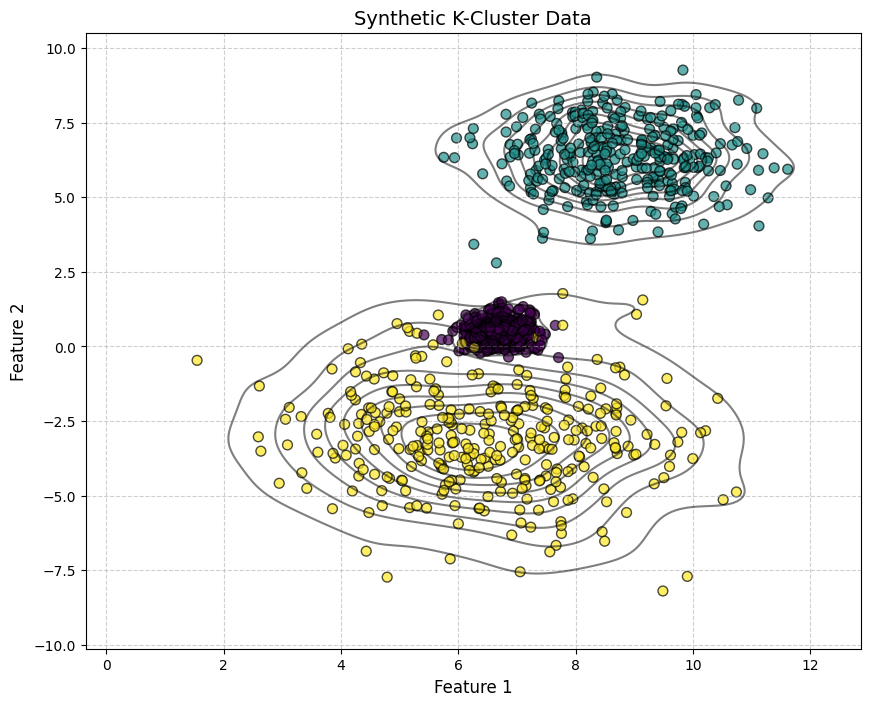

In [4]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters for synthetic data
n_samples = 1000  # Total number of data points
n_features = 2   # Number of features (dimensions)
n_clusters = k =3   # Number of clusters
n_std=[np.sqrt(random.uniform(i,i+1)) for i in range(n_clusters)]


# Generate synthetic data
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, cluster_std=n_std)

# Visualize the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolor='k', alpha=0.7)
for i in range(n_clusters):
    data = X[y == i]
    sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=10, linewidths=1.5, color='k', alpha=0.5)

plt.title("Synthetic K-Cluster Data", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [5]:
# Unsupervised data for GMM MLE Learning via EM algorithm
data = X  # Number of clusters
N = X.shape[0]

In [6]:
# E step

import numpy as np
from scipy.stats import multivariate_normal

## E-step: Calculate responsibilities
def e_step(X, k, mixing_dic, mean_dic, cov_dic):
    N = X.shape[0]  # Number of data points
    responsibilities = np.zeros((N, k))  # Responsibility matrix (N x k)

    for i in range(k):
        # Calculate the probability of X under the i-th Gaussian
        rv = multivariate_normal(mean=mean_dic[i], cov=cov_dic[i], allow_singular = True)
        responsibilities[:, i] = mixing_dic[i] * rv.pdf(X)

    # Normalize responsibilities across clusters for each data point
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)

    return responsibilities


In [7]:

# M-step: Update parameters
def m_step(X, responsibilities, k):
    N, d = X.shape  # Number of data points (N) and dimensions (d)
    
    # Initialize dictionaries for updated parameters
    mixing_dic = {}
    mean_dic = {}
    cov_dic = {}
    
    # Update parameters for each cluster
    for i in range(k):
        # Sum of responsibilities for cluster i
        N_k = responsibilities[:, i].sum()
        
        # Update mixing coefficient
        mixing_dic[i] = N_k / N
        
        # Update mean
        mean_dic[i] = (responsibilities[:, i][:, np.newaxis] * X).sum(axis=0) / N_k
        
        # Update covariance matrix
        diff = X - mean_dic[i]
        cov_dic[i] = (responsibilities[:, i][:, np.newaxis] * diff).T @ diff / N_k
    
    return mixing_dic, mean_dic, cov_dic



In [8]:

# Visualize current associations of data points with clusters and add sigma bands around means
def visualize_clusters(X, responsibilities, k, mean_dic, cov_dic, step):
    """
    Visualize clusters with their corresponding sigma bands (ellipsoids) around the means.
    
    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        The data points.
    responsibilities : array-like, shape (n_samples, k)
        The responsibilities for each cluster.
    k : int
        The number of clusters.
    mean_dic : dict
        Dictionary of cluster means.
    cov_dic : dict
        Dictionary of cluster covariance matrices.
    """
    # Assign each data point to the cluster with the highest responsibility
    cluster_assignments = np.argmax(responsibilities, axis=1)
    
    # Define a list of colors for the clusters
    cluster_colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'brown', 'pink', 'gray']  # Add more colors if needed
    
    plt.figure(figsize=(12, 10))
    
    for i in range(k):
        # Plot data points belonging to cluster i
        cluster_points = X[cluster_assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", alpha=0.6, color=cluster_colors[i % len(cluster_colors)+3])
        
        # Plot the current mean of the cluster
        plt.scatter(mean_dic[i][0], mean_dic[i][1], color=cluster_colors[i % len(cluster_colors)], 
                    marker='x', s=100, label=f"Mean {i}")
        
        # Add an ellipse (sigma band) for the cluster
        
    
        for n in range(1, 4):  # 1-sigma, 2-sigma, 3-sigma bands
            eigenvalues, eigenvectors = np.linalg.eigh(cov_dic[i])  # Eigen decomposition of the covariance matrix
            angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])  # Angle of the first eigenvector
            angle = np.degrees(angle)  # Convert to degrees
            width, height = n * np.sqrt(eigenvalues)  # Scale by 2-sigma, 4-sigma, 6-sigma for 1, 2, 3 bands
            ell = Ellipse(xy=mean_dic[i], width=width, height=height, angle=angle, 
                  edgecolor=cluster_colors[i % len(cluster_colors)], facecolor='none', linestyle='--', linewidth=1.5)
            plt.gca().add_patch(ell)
    plt.title(f'Step {step} : Current Cluster Associations')
    plt.xlim(min(X[:,0])-1,max(X[:,0])+1)
    plt.ylim(min(X[:,1])-1,max(X[:,1])+1)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    

In [9]:
def train_gmm(X, n_components=3, n_steps=10, plot_intermediate_steps_flag=True, tol=1e-4):
    """
    Train a Gaussian Mixture Model (GMM) using the EM algorithm with stopping criteria.
    
    Parameters:
    ----------
    X : array-like, shape (n_samples, n_features)
        The data.
    n_components : int
        The number of clusters.
    n_steps : int
        Maximum number of iterations to run.
    plot_intermediate_steps_flag : bool
        Whether to plot intermediate steps.
    tol : float
        Convergence tolerance for stopping criteria.
    """
    # Step 1: Initialize parameters
    mixing_dic = {}
    X_f1_min = min(X[:, 0]) + random.uniform(-1, 1)
    X_f1_max = max(X[:, 0]) + random.uniform(-1, 1)
    X_f2_min = min(X[:, 1]) + random.uniform(-1, 1)
    X_f2_max = max(X[:, 1]) + random.uniform(-1, 1)
    mean_dic = {}
    cov_dic = {}
    for i in range(n_components):
        mixing_dic[i] = 1 / X.shape[0]
        mean_dic[i] = [random.uniform(X_f1_min, X_f1_max), random.uniform(X_f2_min, X_f2_max)]
        
        mat = [[random.uniform(np.sqrt(abs(X_f1_max - X_f1_min)), -np.sqrt(abs(X_f1_max - X_f1_min))),
                random.uniform(np.sqrt(abs(X_f1_max - X_f2_min)), -np.sqrt(abs(X_f1_max - X_f2_min)))],
               [random.uniform(np.sqrt(abs(X_f2_max - X_f1_min)), -np.sqrt(abs(X_f2_max - X_f1_min))),
                random.uniform(np.sqrt(abs(X_f2_max - X_f2_min)), -np.sqrt(abs(X_f2_max - X_f2_min)))]]
        
        cov_dic[i] = mat @ np.transpose(mat)

    print("Initial Parameters:")
    print(f"Mixing Coefficients: {mixing_dic} \n")
    print(f"Means: {mean_dic} \n")
    print(f"Covariances: {cov_dic} \n")

    # Step 2: Iterate between E-step and M-step
    plt.figure(figsize=(10, 8)) # Create a single figure for dynamic updates
    prev_log_likelihood = None  # Initialize previous log-likelihood
    for step in range(n_steps):
        print(f"\nStep {step + 1}")

        # E-step: Calculate responsibilities
        responsibilities = e_step(X, n_components, mixing_dic, mean_dic, cov_dic)

        # Visualize intermediate steps if flag is set
        if plot_intermediate_steps_flag:
              # Clear the current figure
            visualize_clusters(X, responsibilities, n_components, mean_dic, cov_dic, step)
            plt.savefig(f"Step_{str(step).zfill(2)}", dpi=300, bbox_inches='tight')
            plt.show()

        # M-step: Update parameters
        mixing_dic, mean_dic, cov_dic = m_step(X, responsibilities, n_components)

        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(np.sum([
            mixing_dic[i] * multivariate_normal(mean=mean_dic[i], cov=cov_dic[i], allow_singular= True).pdf(X)
            for i in range(n_components)
        ], axis=0)))
        print(f"Log-Likelihood: {log_likelihood}")

        # Check for convergence
        if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < tol:
            print(f"Convergence reached at step {step + 1}.")
            break
        prev_log_likelihood = log_likelihood

        # Print updated parameters
        print(f"Mixing Coefficients: {mixing_dic} \n")
        print(f"Means: {mean_dic} \n")
        print(f"Covariances: {cov_dic}")

    # Final visualization
    if plot_intermediate_steps_flag:
        plt.clf()  # Clear the figure for the final visualization
        visualize_clusters(X, responsibilities, n_components, mean_dic, cov_dic, step)
        

    print("\nFinal Parameters:")
    print("Mixing Coefficients:", mixing_dic)
    print("Means:", mean_dic)
    print("Covariances:", cov_dic)
    plt.show()  # Ensure the final graph remains displayed
    return mixing_dic, mean_dic, cov_dic

In [10]:
# Define the pattern for the files to delete
file_pattern = "Step_*.png"

# Use glob to find all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through and delete each file
for file in files_to_delete:
    try:
        os.remove(file)  # Delete the file
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting {file}: {e}")

Initial Parameters:
Mixing Coefficients: {0: 0.001, 1: 0.001, 2: 0.001} 

Means: {0: [np.float64(11.180978031770776), np.float64(-2.6456688743231016)], 1: [np.float64(3.058580805677553), np.float64(6.369376815865769)], 2: [np.float64(11.7326864859657), np.float64(-4.609727819103092)]} 

Covariances: {0: array([[10.47067739,  5.52986615],
       [ 5.52986615,  2.95787831]]), 1: array([[24.35930541, 14.29052149],
       [14.29052149, 10.72284302]]), 2: array([[13.89823451,  4.60063085],
       [ 4.60063085,  6.83306829]])} 


Step 1


<Figure size 1000x800 with 0 Axes>

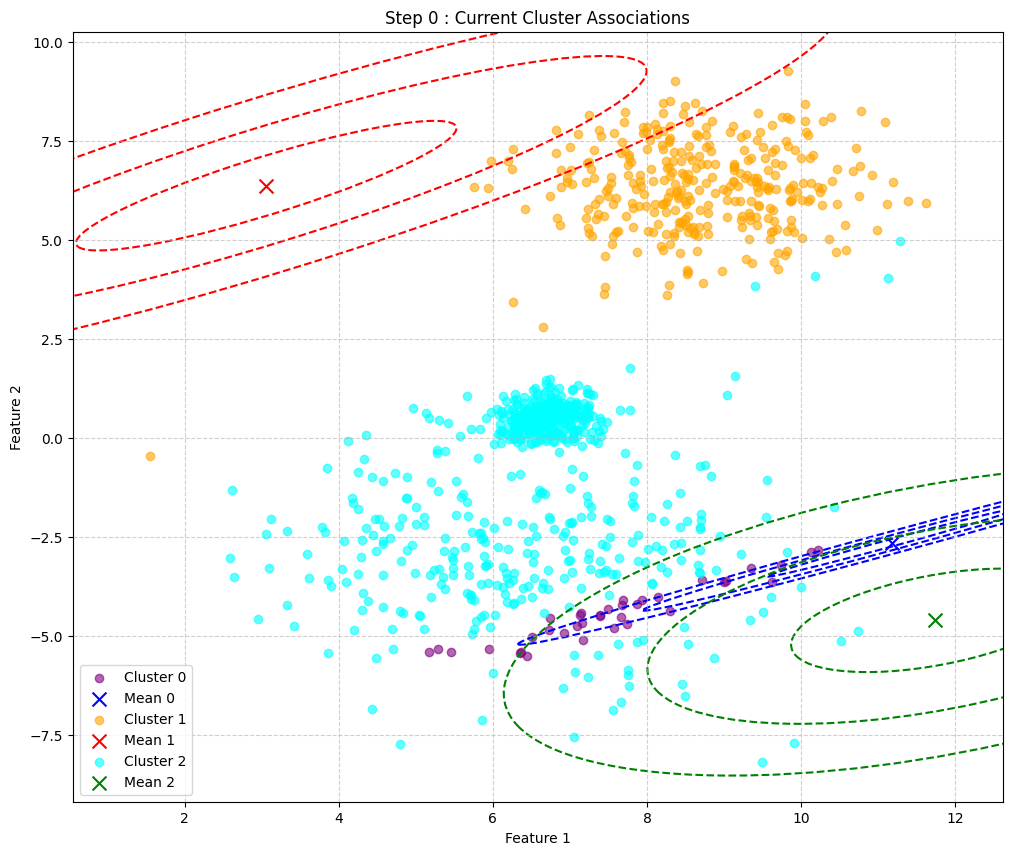

Log-Likelihood: -4157.769981572266
Mixing Coefficients: {0: np.float64(0.03397507905370403), 1: np.float64(0.3270051023222942), 2: np.float64(0.6390198186240017)} 

Means: {0: array([ 7.69587222, -4.36286577]), 1: array([8.66456956, 6.34853047]), 2: array([ 6.56055647, -1.04579961])} 

Covariances: {0: array([[1.679393  , 0.91440387],
       [0.91440387, 0.56965601]]), 1: array([[1.29118141, 0.19470087],
       [0.19470087, 1.29408333]]), 2: array([[1.4712756 , 0.43235136],
       [0.43235136, 4.60638384]])}

Step 2


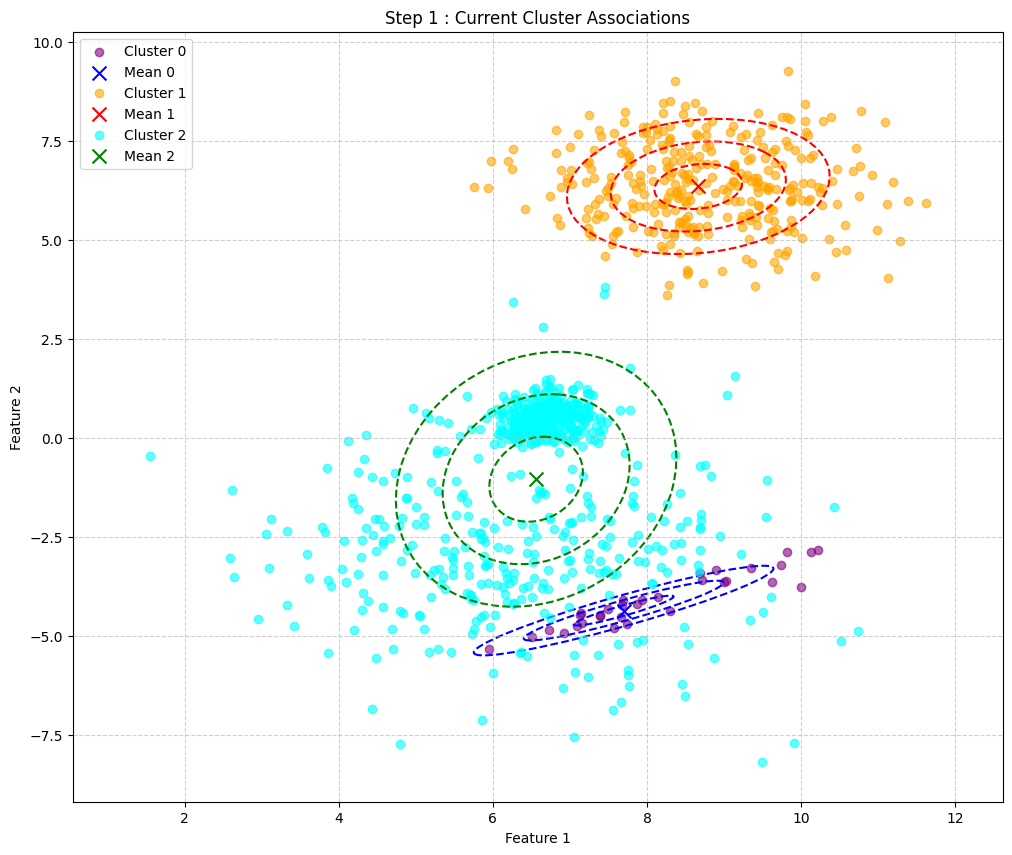

Log-Likelihood: -4141.799007196752
Mixing Coefficients: {0: np.float64(0.028640962283036774), 1: np.float64(0.3263672593901009), 2: np.float64(0.6449917783268624)} 

Means: {0: array([ 8.0264016 , -4.13986137]), 1: array([8.73816763, 6.37649008]), 2: array([ 6.52010829, -1.08996972])} 

Covariances: {0: array([[1.64107945, 0.90666771],
       [0.90666771, 0.59198689]]), 1: array([[ 1.16604453, -0.06258393],
       [-0.06258393,  1.09872795]]), 2: array([[1.35361203, 0.27707852],
       [0.27707852, 4.66456334]])}

Step 3


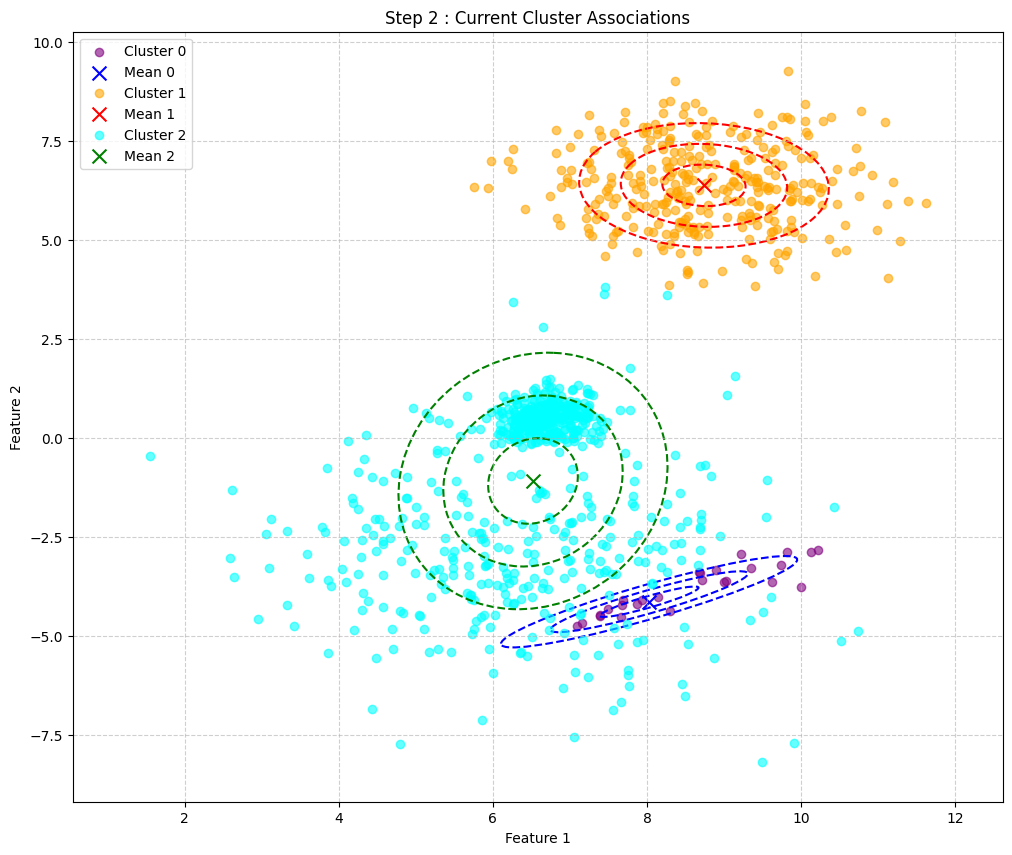

Log-Likelihood: -4140.551597721923
Mixing Coefficients: {0: np.float64(0.026865391043802717), 1: np.float64(0.3257447207263484), 2: np.float64(0.6473898882298488)} 

Means: {0: array([ 8.2173166 , -4.01289674]), 1: array([8.74343544, 6.38116996]), 2: array([ 6.51579928, -1.09877823])} 

Covariances: {0: array([[1.5385274 , 0.8451473 ],
       [0.8451473 , 0.57144397]]), 1: array([[ 1.16211339, -0.07288521],
       [-0.07288521,  1.08818141]]), 2: array([[1.33423675, 0.27969733],
       [0.27969733, 4.73146115]])}

Step 4


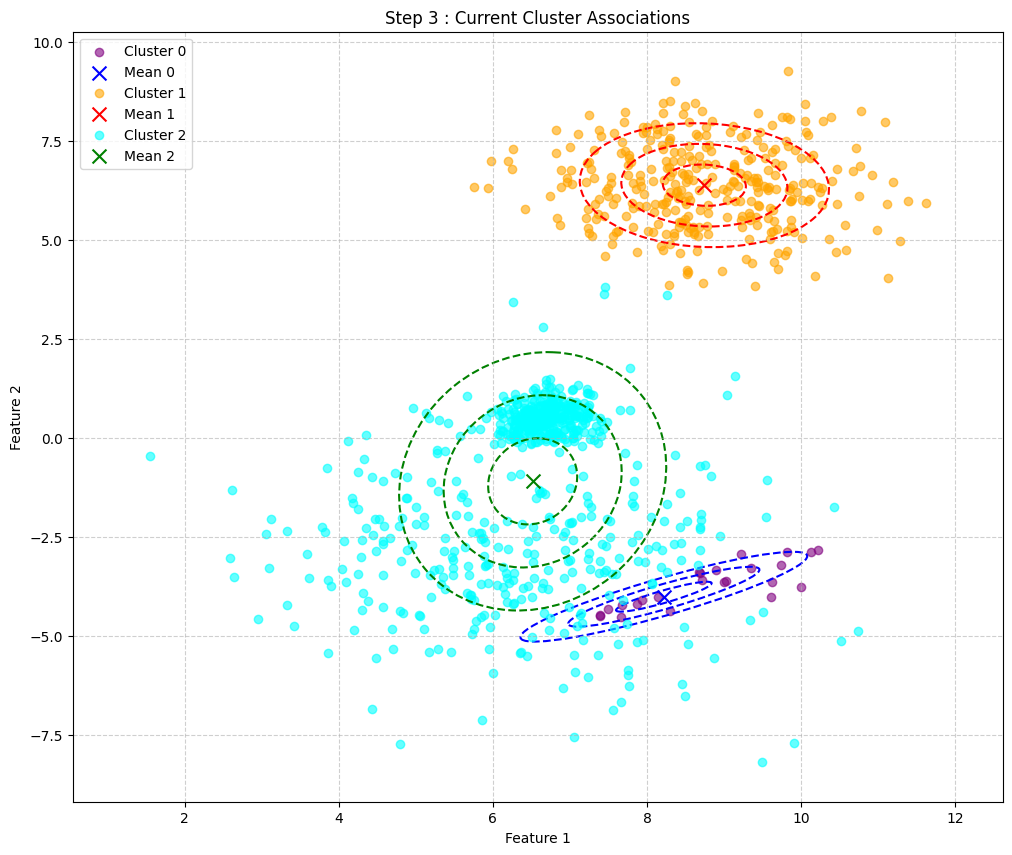

Log-Likelihood: -4139.787212853993
Mixing Coefficients: {0: np.float64(0.026253789411151415), 1: np.float64(0.32552214859667994), 2: np.float64(0.6482240619921686)} 

Means: {0: array([ 8.33829562, -3.93747719]), 1: array([8.74422769, 6.38224339]), 2: array([ 6.51287191, -1.10255304])} 

Covariances: {0: array([[1.42631463, 0.77411478],
       [0.77411478, 0.54612514]]), 1: array([[ 1.16166177, -0.07391231],
       [-0.07391231,  1.0865454 ]]), 2: array([[1.32452908, 0.28906882],
       [0.28906882, 4.7648487 ]])}

Step 5


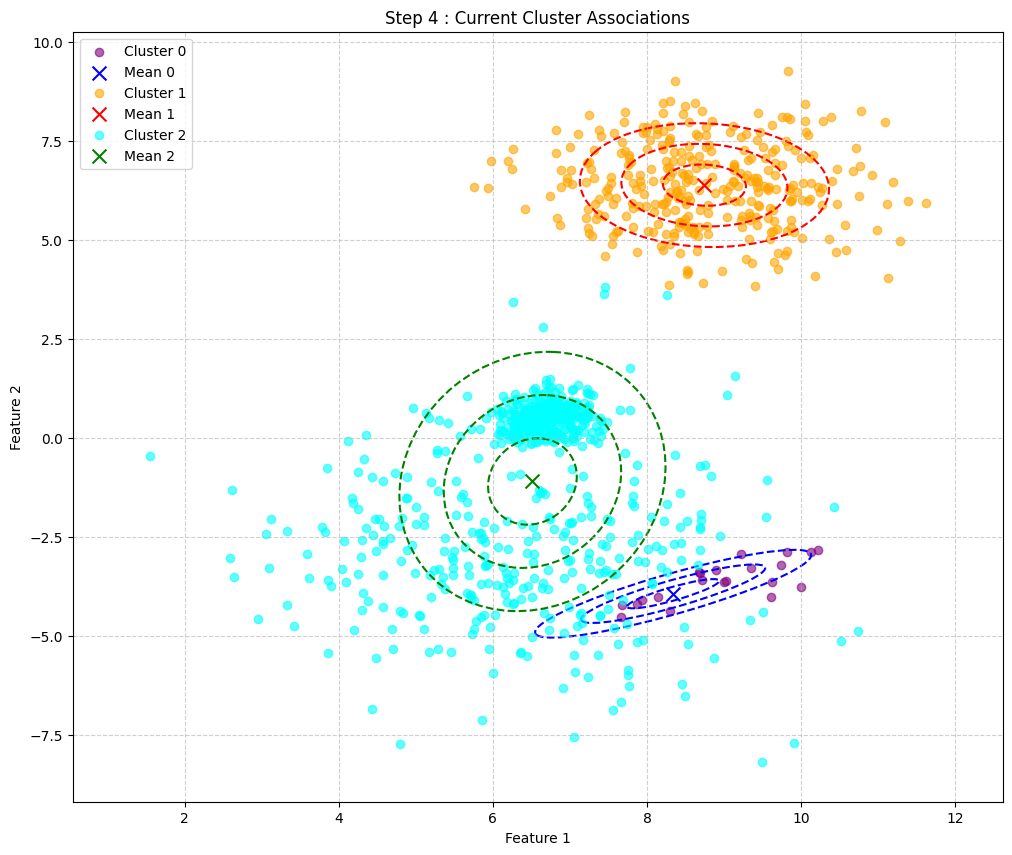

Log-Likelihood: -4138.9692565139185
Mixing Coefficients: {0: np.float64(0.02627432564165634), 1: np.float64(0.32542585164553806), 2: np.float64(0.6482998227128056)} 

Means: {0: array([ 8.42641689, -3.88832915]), 1: array([8.74452053, 6.38266727]), 2: array([ 6.50942715, -1.10355612])} 

Covariances: {0: array([[1.33312507, 0.71578219],
       [0.71578219, 0.53640529]]), 1: array([[ 1.16153532, -0.07424742],
       [-0.07424742,  1.08596774]]), 2: array([[1.31495473, 0.29891107],
       [0.29891107, 4.78119615]])}

Step 6


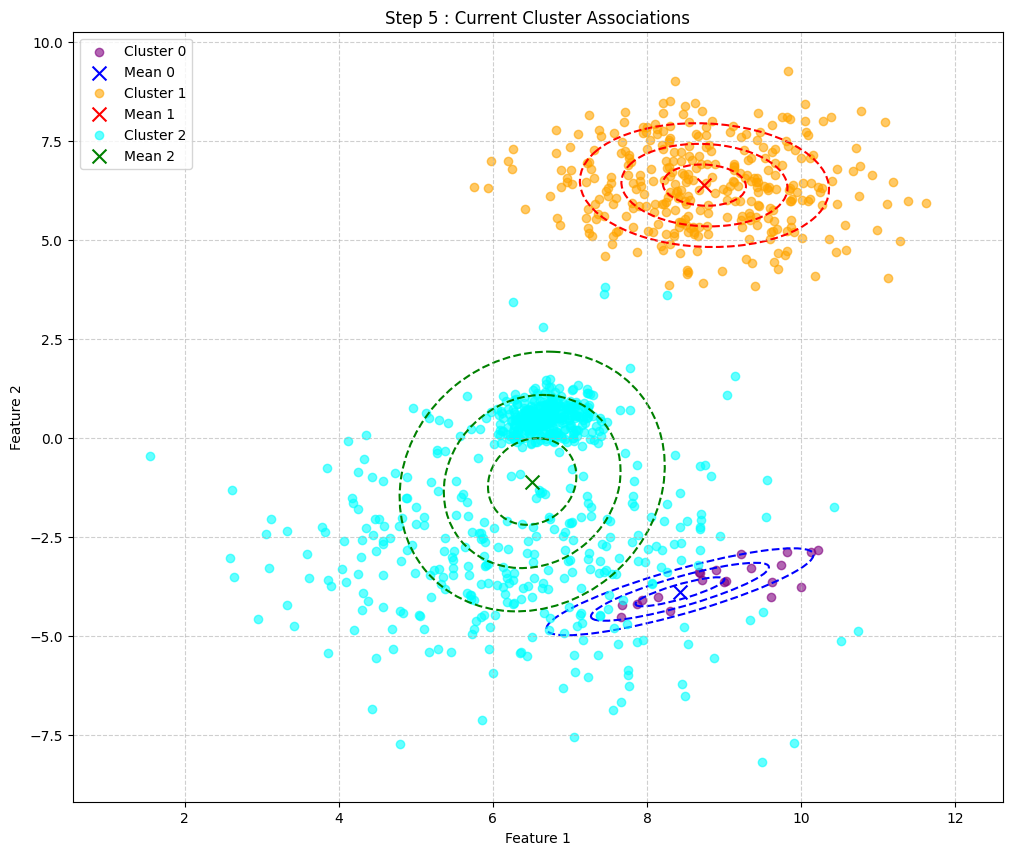

Log-Likelihood: -4137.840087115728
Mixing Coefficients: {0: np.float64(0.026860088987128355), 1: np.float64(0.3253712757313778), 2: np.float64(0.6477686352814939)} 

Means: {0: array([ 8.49751887, -3.85514227]), 1: array([8.74468224, 6.38290615]), 2: array([ 6.50485246, -1.10190328])} 

Covariances: {0: array([[1.25526548, 0.67011032],
       [0.67011032, 0.54900529]]), 1: array([[ 1.161494  , -0.0744453 ],
       [-0.0744453 ,  1.08565196]]), 2: array([[1.30337511, 0.31133875],
       [0.31133875, 4.78788796]])}

Step 7


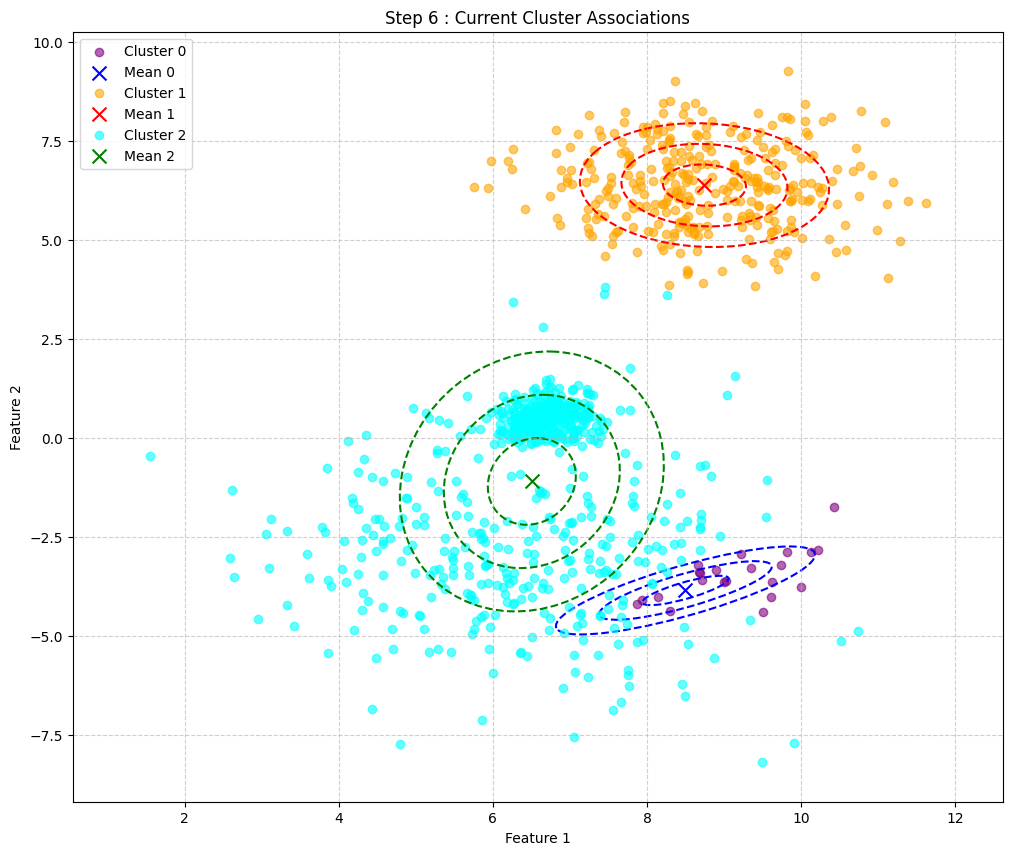

Log-Likelihood: -4136.356465219641
Mixing Coefficients: {0: np.float64(0.02809069554647549), 1: np.float64(0.32532942013317734), 2: np.float64(0.6465798843203472)} 

Means: {0: array([ 8.55574514, -3.83421238]), 1: array([8.74479756, 6.38309906]), 2: array([ 6.49861723, -1.09718501])} 

Covariances: {0: array([[1.18485463, 0.63411248],
       [0.63411248, 0.58776736]]), 1: array([[ 1.16150675, -0.07461349],
       [-0.07461349,  1.08539341]]), 2: array([[1.28874996, 0.32828407],
       [0.32828407, 4.786874  ]])}

Step 8


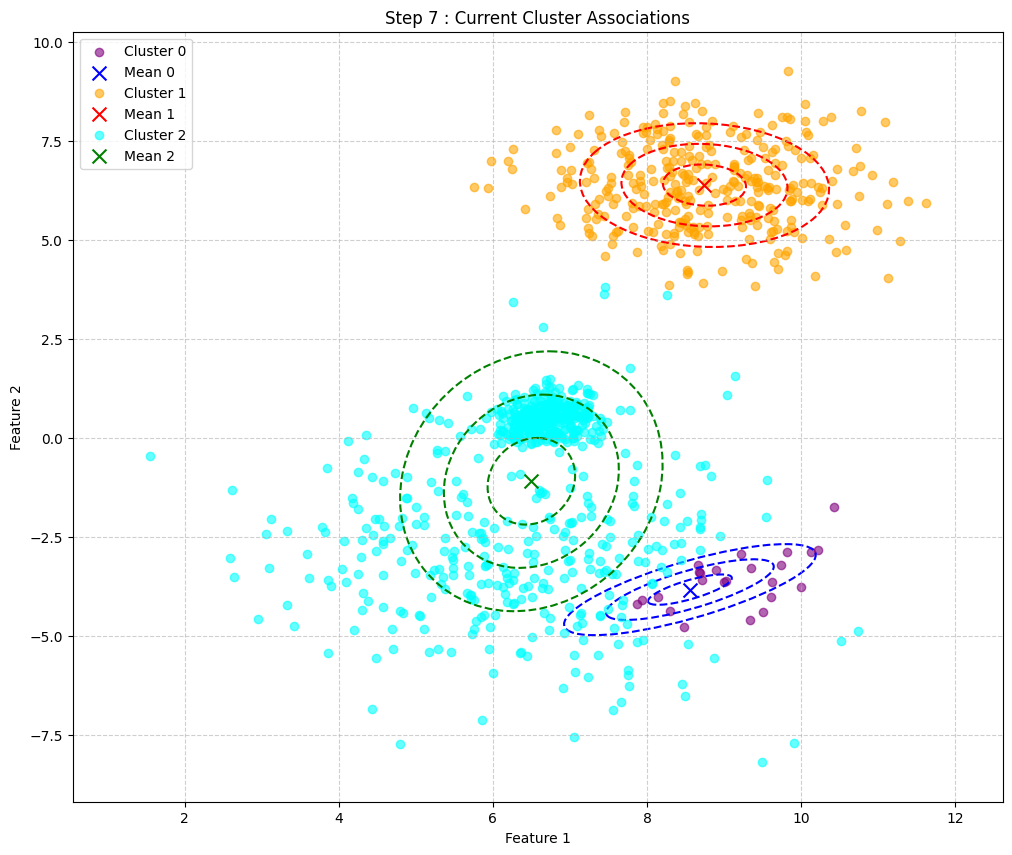

Log-Likelihood: -4134.548662659274
Mixing Coefficients: {0: np.float64(0.02993998654217913), 1: np.float64(0.325288253191587), 2: np.float64(0.644771760266234)} 

Means: {0: array([ 8.59608536, -3.82441224]), 1: array([8.74489475, 6.38330589]), 2: array([ 6.4909383 , -1.08941667])} 

Covariances: {0: array([[1.1195123 , 0.60544425],
       [0.60544425, 0.65207896]]), 1: array([[ 1.16157574, -0.07479234],
       [-0.07479234,  1.08510414]]), 2: array([[1.27216241, 0.34965517],
       [0.34965517, 4.77879249]])}

Step 9


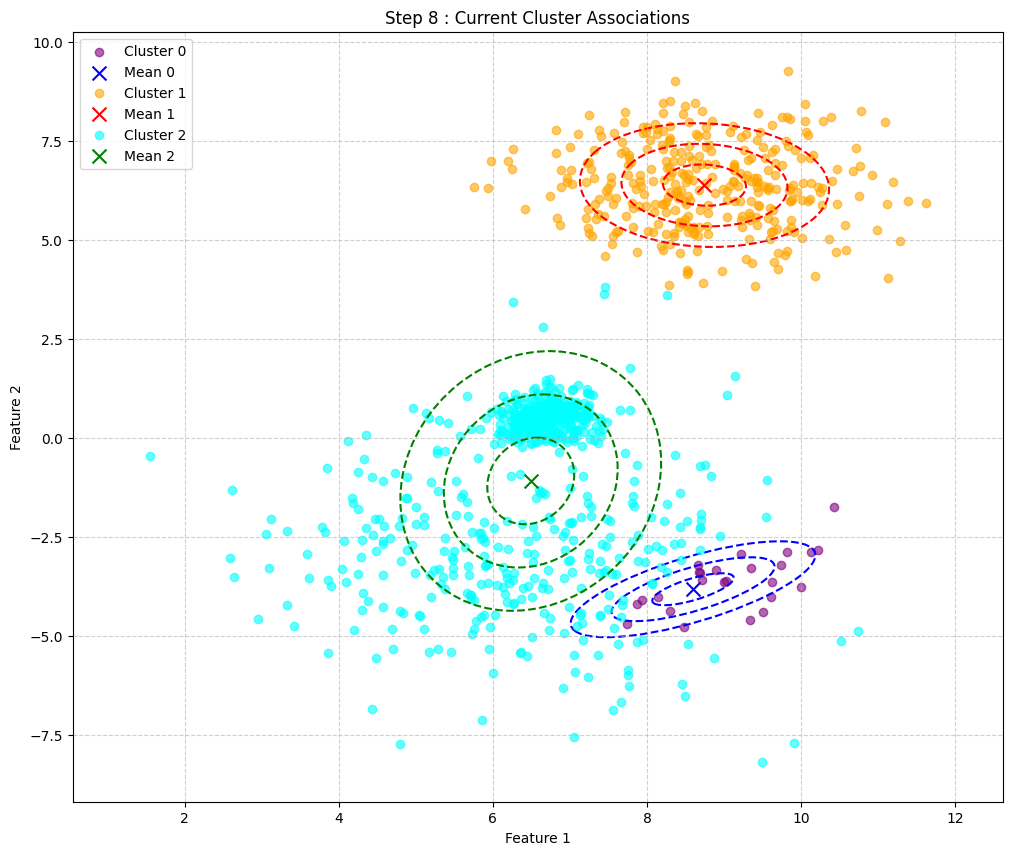

Log-Likelihood: -4130.951164434251
Mixing Coefficients: {0: np.float64(0.032470547527810166), 1: np.float64(0.3252441982523485), 2: np.float64(0.6422852542198414)} 

Means: {0: array([ 8.62402513, -3.83273389]), 1: array([8.74497707, 6.38354737]), 2: array([ 6.48134458, -1.07782999])} 

Covariances: {0: array([[1.07976744, 0.56925239],
       [0.56925239, 0.74467402]]), 1: array([[ 1.16170522, -0.07498721],
       [-0.07498721,  1.08474992]]), 2: array([[1.25132164, 0.37867088],
       [0.37867088, 4.76038858]])}

Step 10


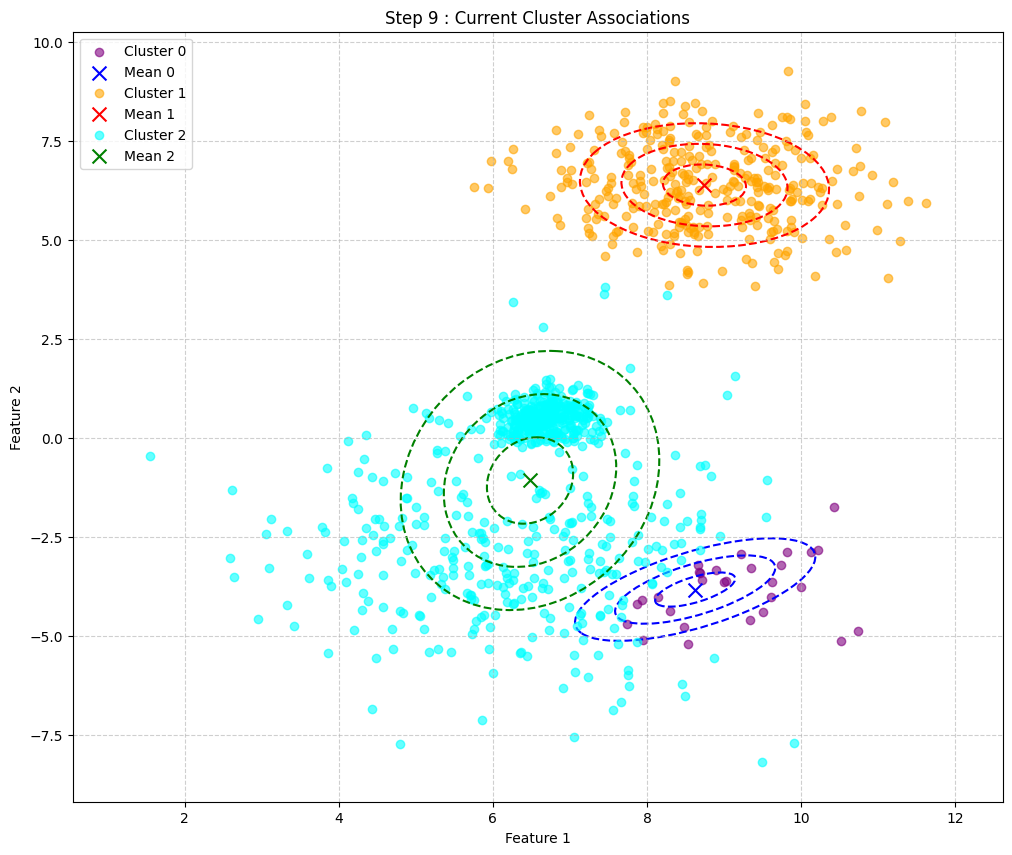

Log-Likelihood: -4122.852708053351
Mixing Coefficients: {0: np.float64(0.036693335922492354), 1: np.float64(0.3251935985050607), 2: np.float64(0.638113065572447)} 

Means: {0: array([ 8.66778437, -3.88700324]), 1: array([8.7450383 , 6.38385621]), 2: array([ 6.46479715, -1.05604418])} 

Covariances: {0: array([[1.10753408, 0.48049982],
       [0.48049982, 0.89626728]]), 1: array([[ 1.16193997, -0.07521657],
       [-0.07521657,  1.08427248]]), 2: array([[1.20944945, 0.43652305],
       [0.43652305, 4.71220119]])}

Step 11


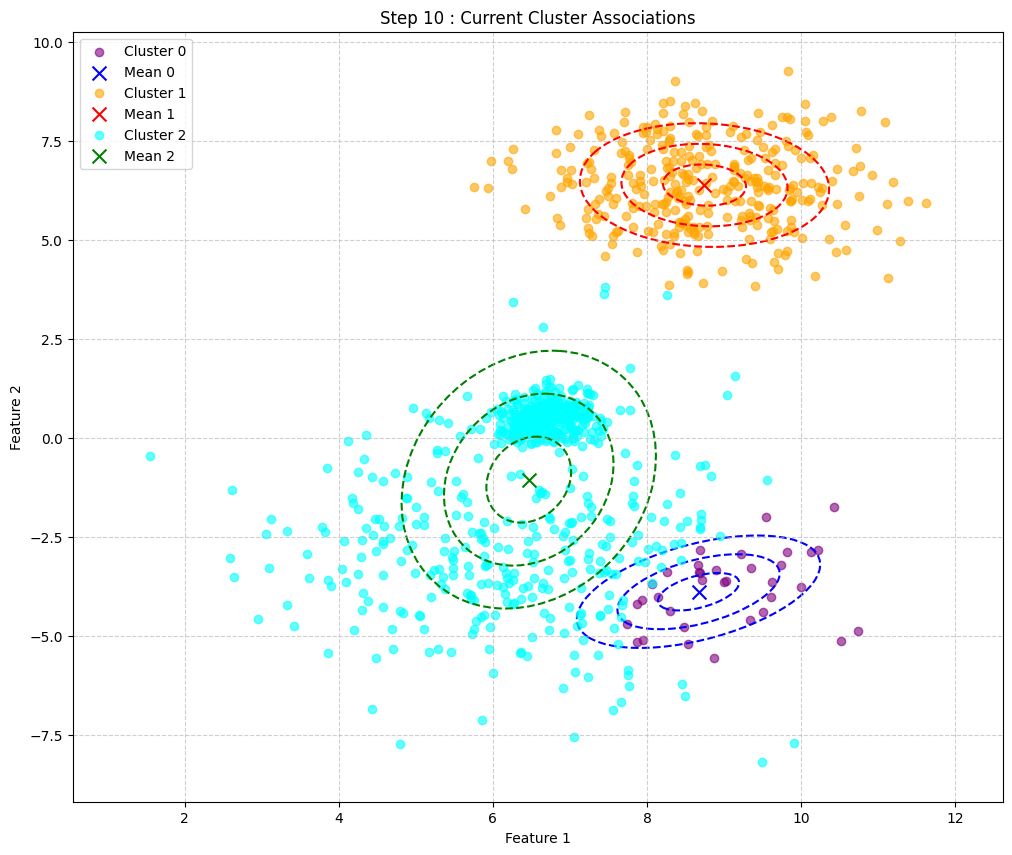

Log-Likelihood: -4113.938824866566
Mixing Coefficients: {0: np.float64(0.043034200538408965), 1: np.float64(0.3251142590287763), 2: np.float64(0.6318515404328148)} 

Means: {0: array([ 8.64485231, -3.97413619]), 1: array([8.74506161, 6.38441462]), 2: array([ 6.44452555, -1.02105312])} 

Covariances: {0: array([[1.09616554, 0.44339098],
       [0.44339098, 1.18059536]]), 1: array([[ 1.16252853, -0.07561177],
       [-0.07561177,  1.08336263]]), 2: array([[1.16926745, 0.51194549],
       [0.51194549, 4.61804928]])}

Step 12


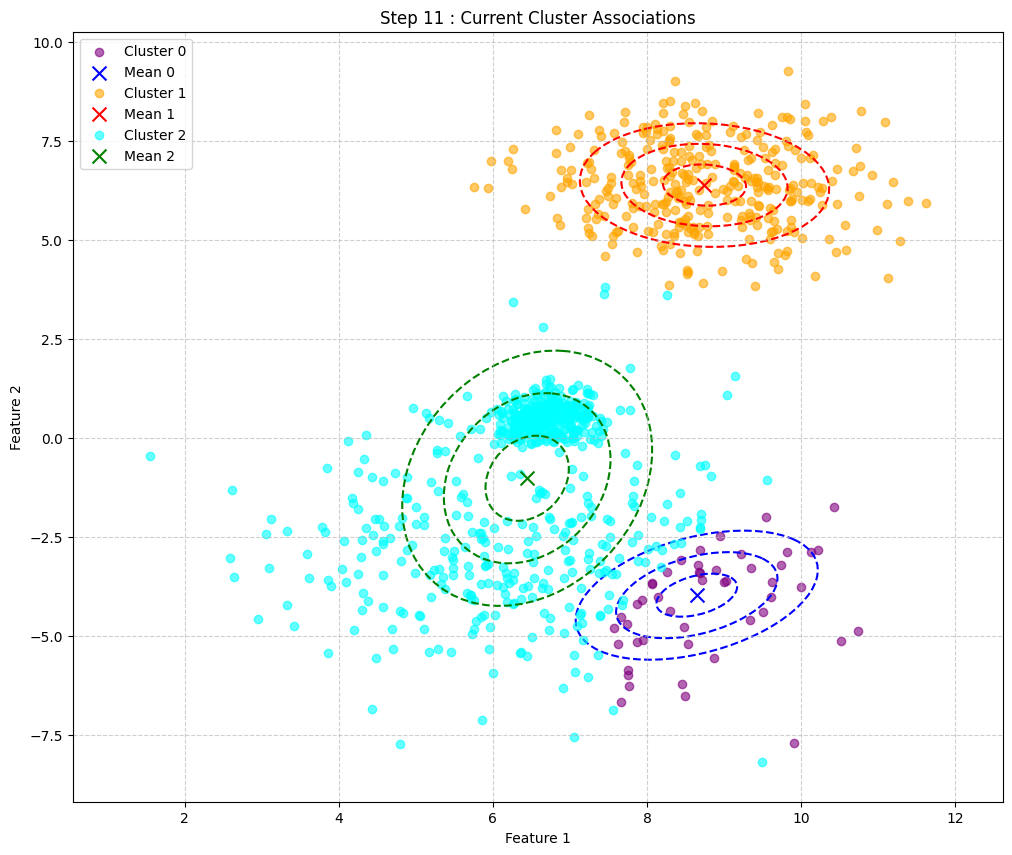

Log-Likelihood: -4096.423335760077
Mixing Coefficients: {0: np.float64(0.052224485739746127), 1: np.float64(0.3250401520811391), 2: np.float64(0.6227353621791147)} 

Means: {0: array([ 8.57702107, -4.14048558]), 1: array([8.74487092, 6.38513239]), 2: array([ 6.41811511, -0.96301453])} 

Covariances: {0: array([[1.06929726, 0.39712868],
       [0.39712868, 1.78779865]]), 1: array([[ 1.16354113, -0.07595622],
       [-0.07595622,  1.08204752]]), 2: array([[1.12565825, 0.62922637],
       [0.62922637, 4.40231696]])}

Step 13


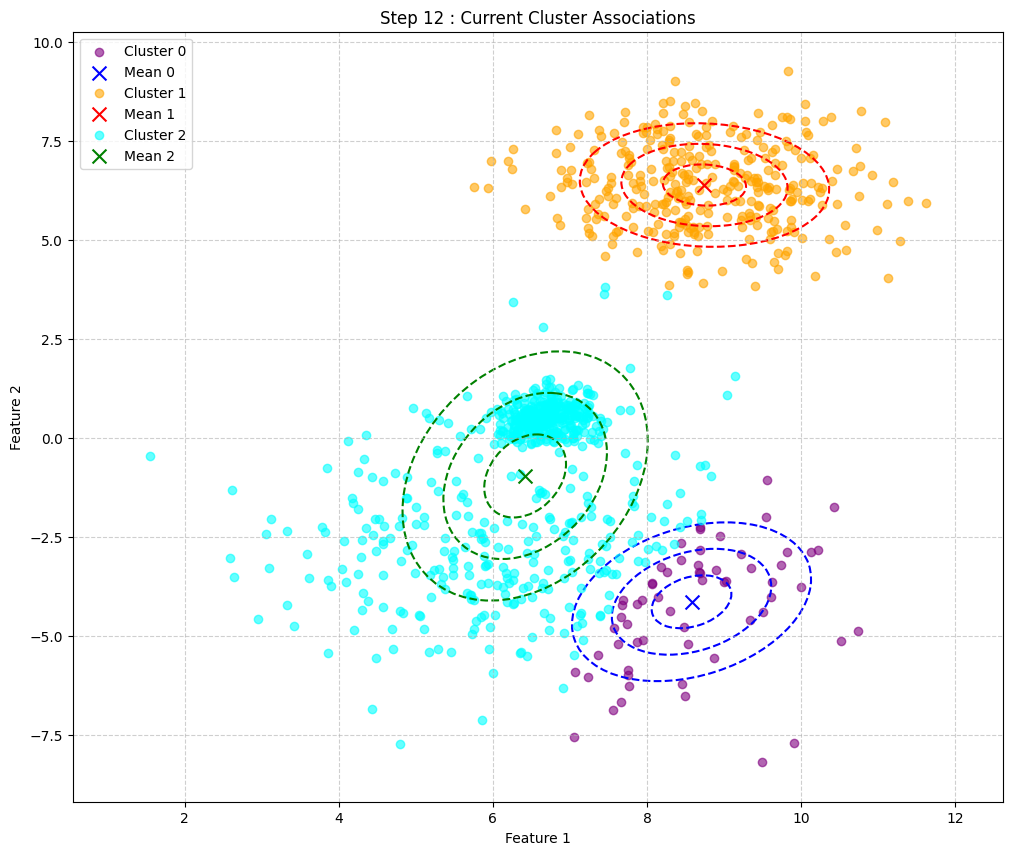

Log-Likelihood: -4084.3974750795087
Mixing Coefficients: {0: np.float64(0.06406401309136443), 1: np.float64(0.32503481518531424), 2: np.float64(0.6109011717233214)} 

Means: {0: array([ 8.46977835, -4.2116801 ]), 1: array([8.74402423, 6.38598798]), 2: array([ 6.38799174, -0.89435877])} 

Covariances: {0: array([[1.06064164, 0.41847577],
       [0.41847577, 2.22555805]]), 1: array([[ 1.16553497, -0.07595642],
       [-0.07595642,  1.08003   ]]), 2: array([[1.08485729, 0.74847873],
       [0.74847873, 4.15354377]])}

Step 14


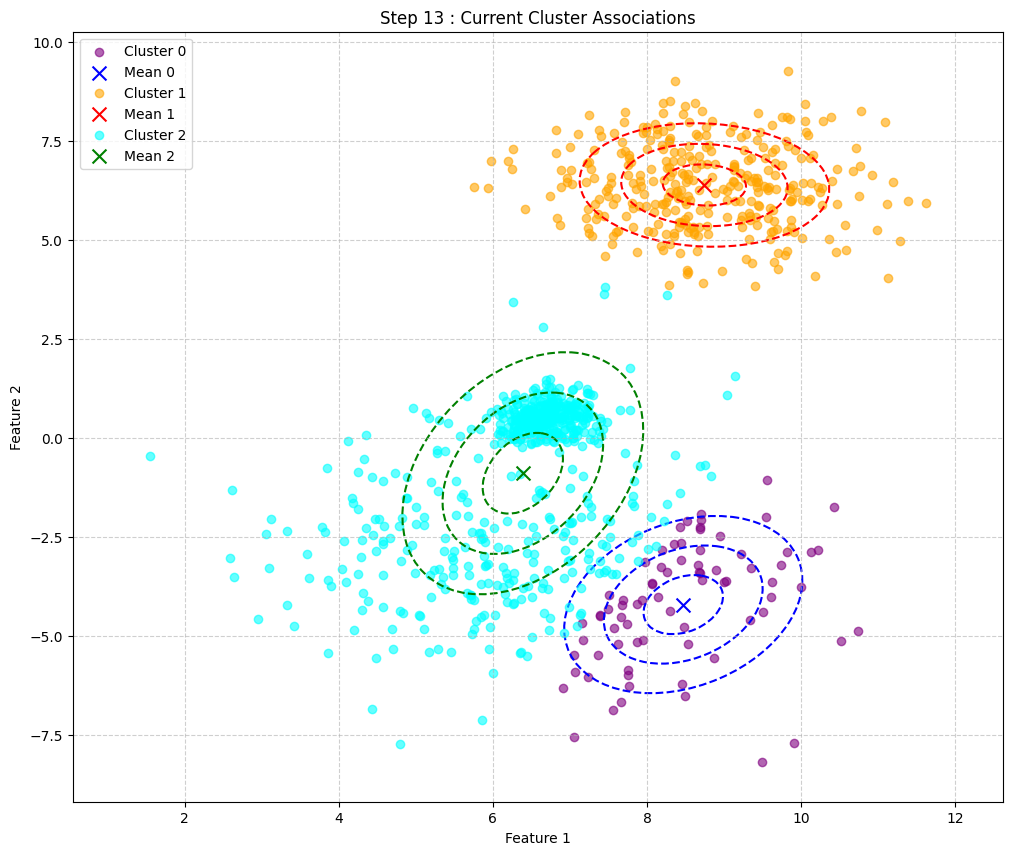

Log-Likelihood: -4074.415807132089
Mixing Coefficients: {0: np.float64(0.07693825451200718), 1: np.float64(0.32507575330756877), 2: np.float64(0.5979859921804241)} 

Means: {0: array([ 8.34295751, -4.15566237]), 1: array([8.74300877, 6.38669291]), 2: array([ 6.35988004, -0.83102805])} 

Covariances: {0: array([[1.07127027, 0.44654122],
       [0.44654122, 2.27199244]]), 1: array([[ 1.16747863, -0.07565491],
       [-0.07565491,  1.07803657]]), 2: array([[1.05694265, 0.83604906],
       [0.83604906, 3.98764458]])}

Step 15


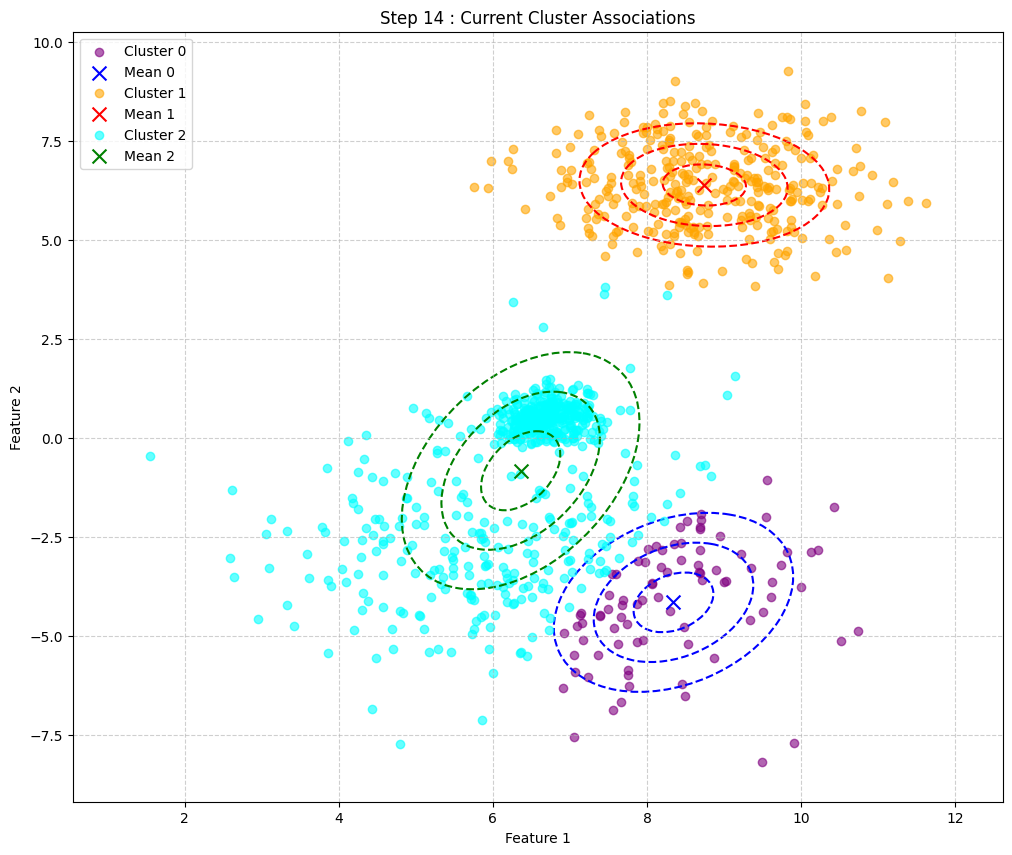

Log-Likelihood: -4064.9136894937938
Mixing Coefficients: {0: np.float64(0.08990287609139253), 1: np.float64(0.3250536082145414), 2: np.float64(0.5850435156940662)} 

Means: {0: array([ 8.22031419, -4.09126831]), 1: array([8.74244759, 6.38738813]), 2: array([ 6.33518329, -0.76736224])} 

Covariances: {0: array([[1.10715755, 0.44938442],
       [0.44938442, 2.24693153]]), 1: array([[ 1.16869138, -0.07551671],
       [-0.07551671,  1.07635285]]), 2: array([[1.03682155, 0.91272048],
       [0.91272048, 3.84290218]])}

Step 16


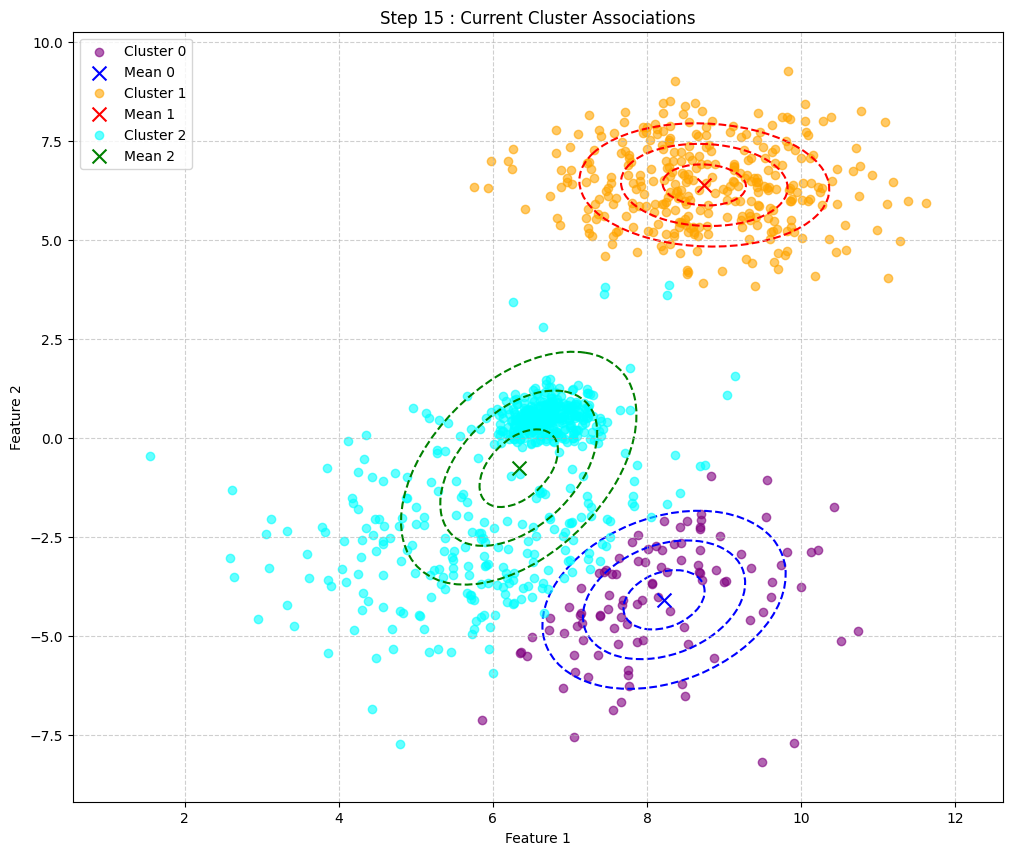

Log-Likelihood: -4055.9300670256453
Mixing Coefficients: {0: np.float64(0.1027110033203547), 1: np.float64(0.32500595870024956), 2: np.float64(0.5722830379793956)} 

Means: {0: array([ 8.10100467, -4.03454942]), 1: array([8.74199157, 6.38814254]), 2: array([ 6.31486523, -0.7029831 ])} 

Covariances: {0: array([[1.1650487 , 0.45095063],
       [0.45095063, 2.22573893]]), 1: array([[ 1.16971423, -0.07537555],
       [-0.07537555,  1.07462123]]), 2: array([[1.02424739, 0.97729748],
       [0.97729748, 3.69698904]])}

Step 17


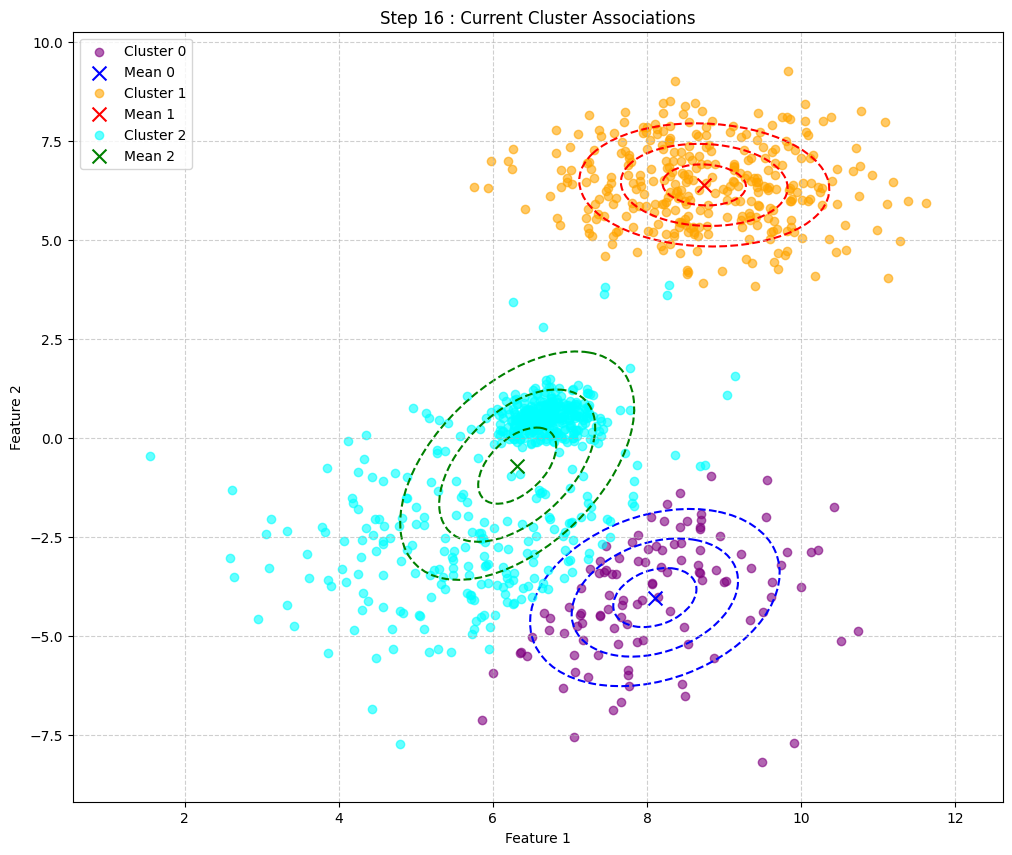

Log-Likelihood: -4047.3095741554507
Mixing Coefficients: {0: np.float64(0.11534582312141109), 1: np.float64(0.3249827791009567), 2: np.float64(0.5596713977776321)} 

Means: {0: array([ 7.98320301, -3.98695497]), 1: array([8.74149419, 6.38875652]), 2: array([ 6.29921012, -0.63764341])} 

Covariances: {0: array([[1.24318731, 0.45676519],
       [0.45676519, 2.21342674]]), 1: array([[ 1.17059786, -0.07506263],
       [-0.07506263,  1.07305887]]), 2: array([[1.01770535, 1.02776337],
       [1.02776337, 3.54061575]])}

Step 18


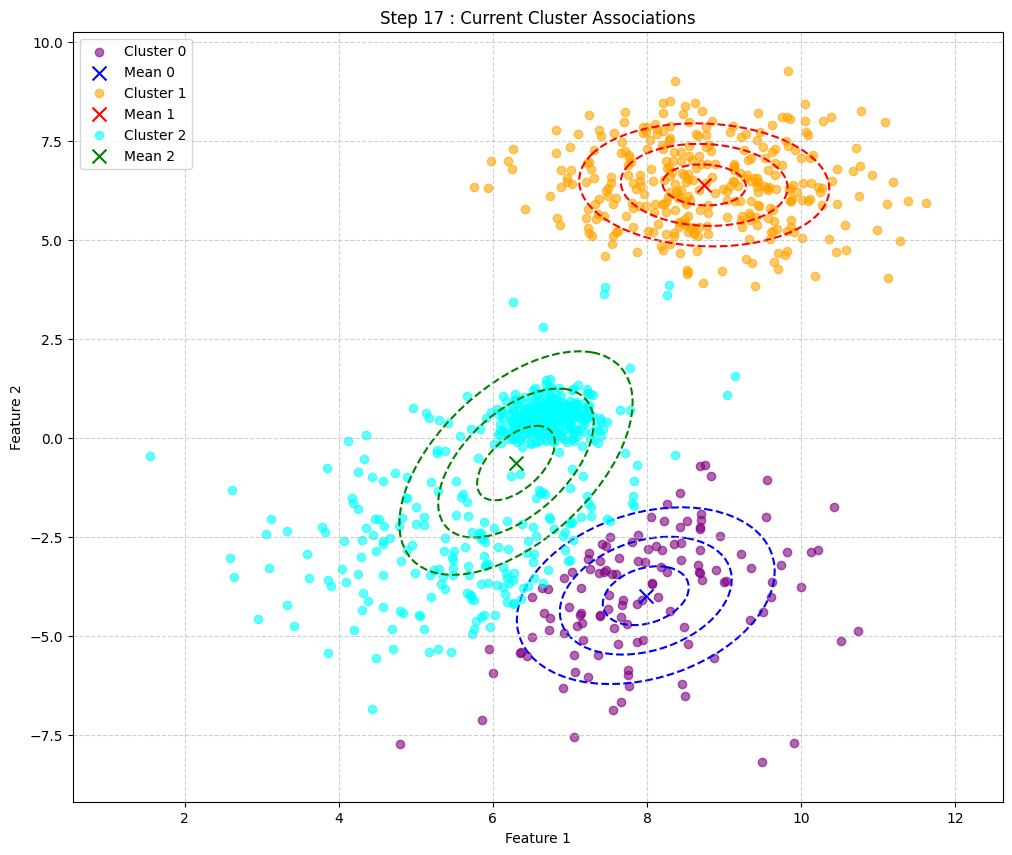

Log-Likelihood: -4038.551280235988
Mixing Coefficients: {0: np.float64(0.12805129180413996), 1: np.float64(0.3250156949588368), 2: np.float64(0.5469330132370231)} 

Means: {0: array([ 7.86351056, -3.94841089]), 1: array([8.74090614, 6.38906118]), 2: array([ 6.28831589, -0.56946567])} 

Covariances: {0: array([[1.34149718, 0.46867686],
       [0.46867686, 2.20494284]]), 1: array([[ 1.17131039, -0.07449318],
       [-0.07449318,  1.07191699]]), 2: array([[1.01539666, 1.06274007],
       [1.06274007, 3.36360242]])}

Step 19


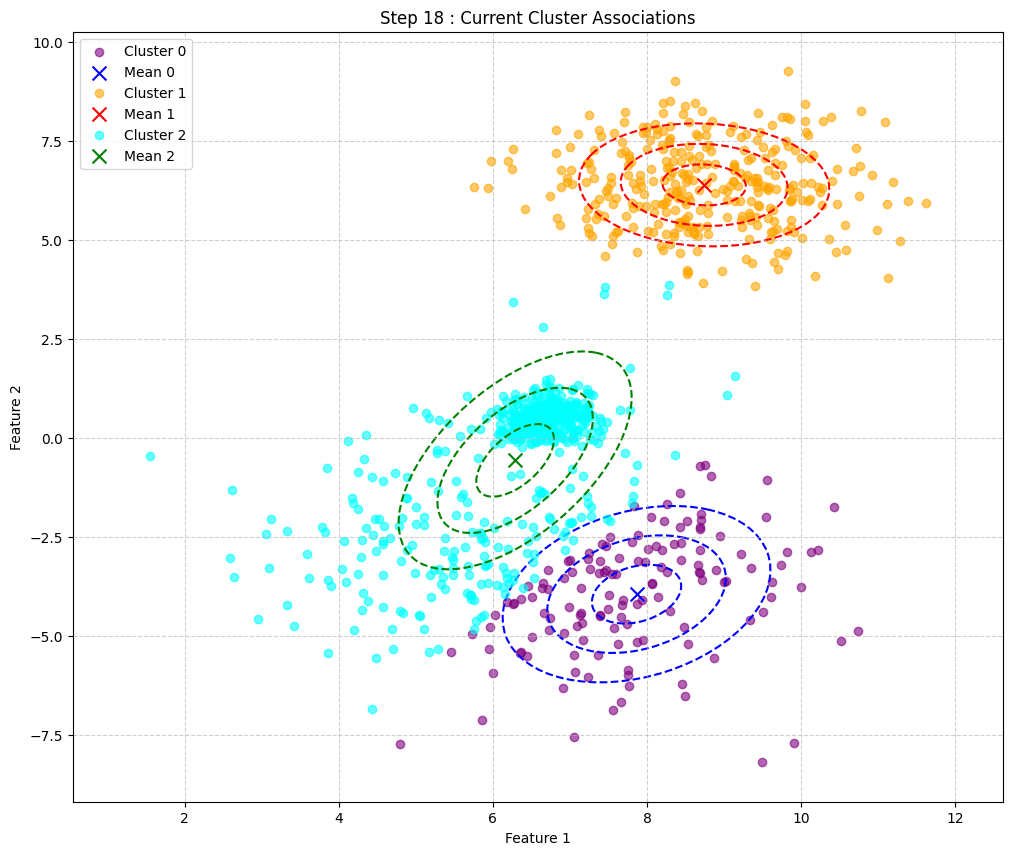

Log-Likelihood: -4028.9058728987493
Mixing Coefficients: {0: np.float64(0.14125349291400768), 1: np.float64(0.3251309603227815), 2: np.float64(0.5336155467632109)} 

Means: {0: array([ 7.73889756, -3.91758327]), 1: array([8.74019653, 6.38890283]), 2: array([ 6.28223286, -0.49543407])} 

Covariances: {0: array([[1.45782387, 0.48396785],
       [0.48396785, 2.19175827]]), 1: array([[ 1.17181568, -0.07359676],
       [-0.07359676,  1.07144135]]), 2: array([[1.01539924, 1.08148637],
       [1.08148637, 3.1543668 ]])}

Step 20


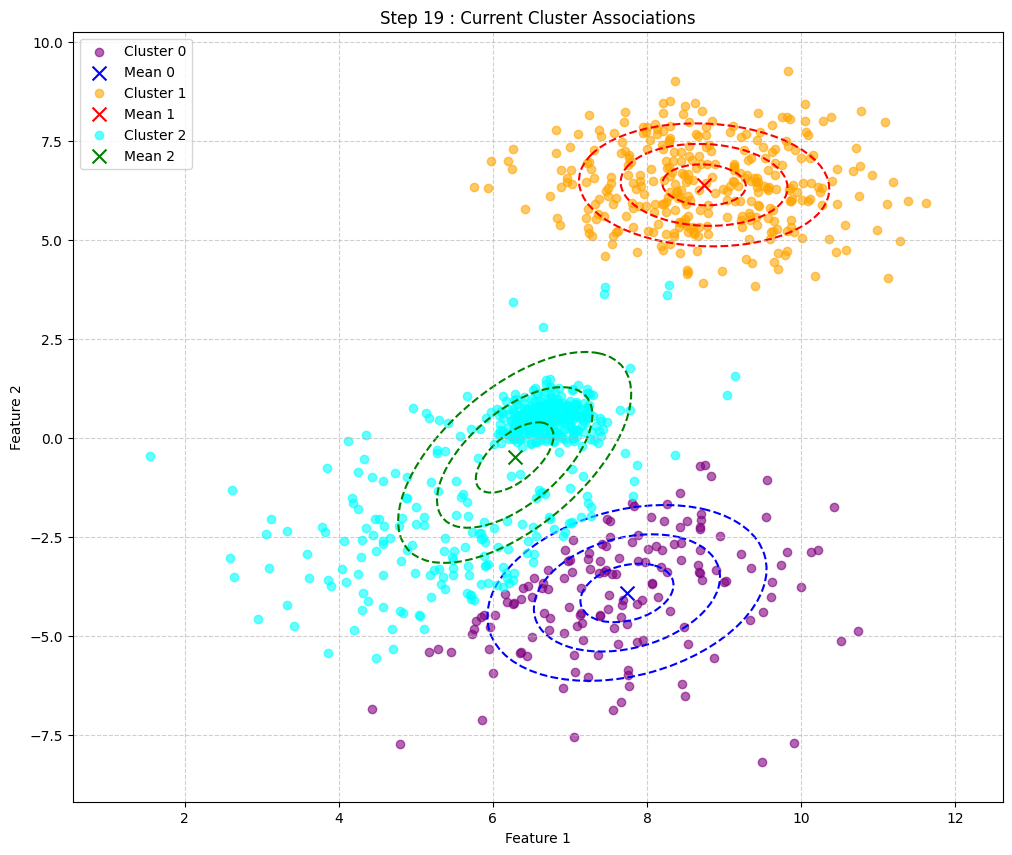

Log-Likelihood: -4017.4413067710566
Mixing Coefficients: {0: np.float64(0.15538166579464643), 1: np.float64(0.32535360903198546), 2: np.float64(0.5192647251733681)} 

Means: {0: array([ 7.60826496, -3.8896591 ]), 1: array([8.73933607, 6.38811445]), 2: array([ 6.28117482, -0.41313785])} 

Covariances: {0: array([[1.5896428 , 0.49302029],
       [0.49302029, 2.1652295 ]]), 1: array([[ 1.17208474, -0.07228389],
       [-0.07228389,  1.0719297 ]]), 2: array([[1.01478251, 1.08324343],
       [1.08324343, 2.90711021]])}

Step 21


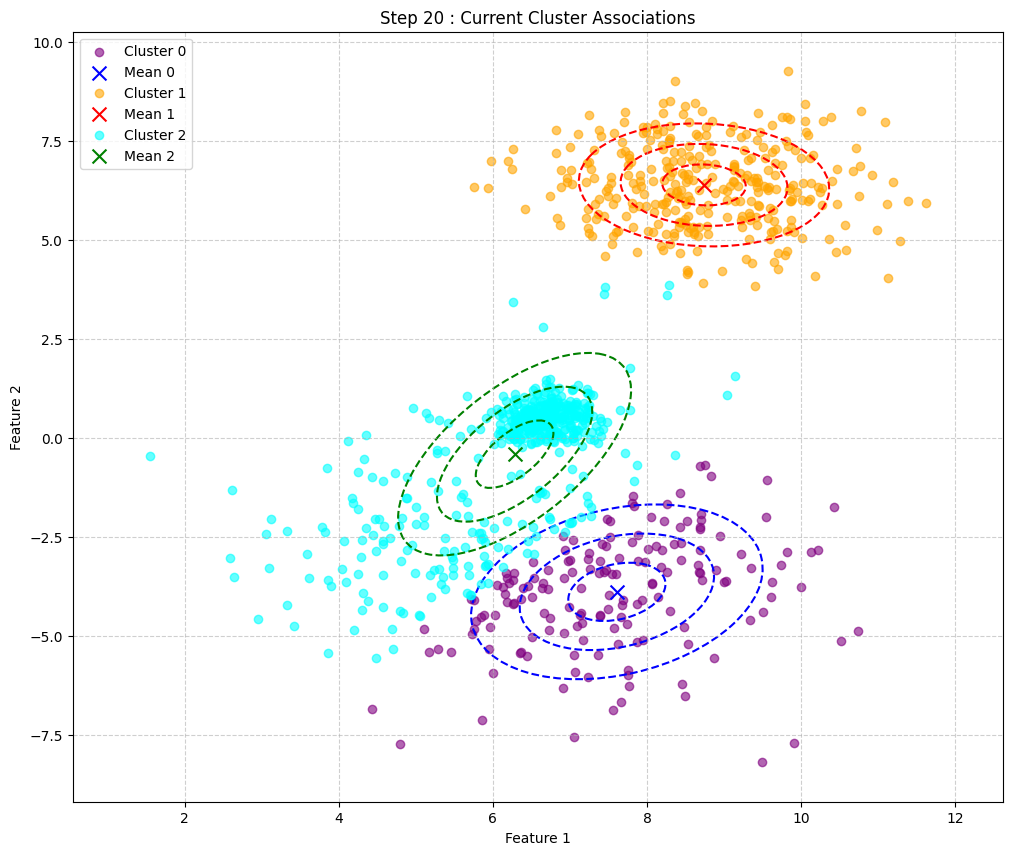

Log-Likelihood: -4001.5792476762695
Mixing Coefficients: {0: np.float64(0.170911259691169), 1: np.float64(0.32570200623312484), 2: np.float64(0.5033867340757061)} 

Means: {0: array([ 7.46749912, -3.85614202]), 1: array([8.73831697, 6.38651262]), 2: array([ 6.28698506, -0.32093697])} 

Covariances: {0: array([[1.75823961, 0.47406961],
       [0.47406961, 2.13030222]]), 1: array([[ 1.17211022, -0.0704608 ],
       [-0.0704608 ,  1.07380478]]), 2: array([[1.00449702, 1.06510887],
       [1.06510887, 2.62137426]])}

Step 22


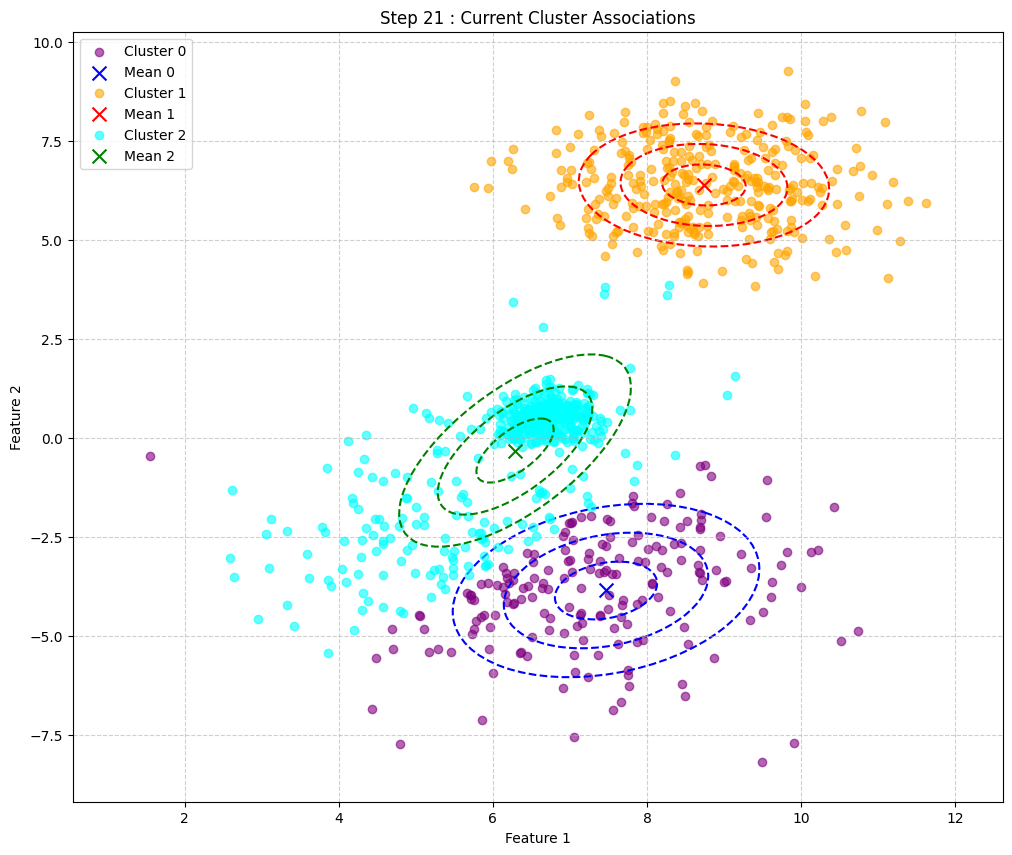

Log-Likelihood: -3974.3125352629377
Mixing Coefficients: {0: np.float64(0.18930580527297436), 1: np.float64(0.3261989700723822), 2: np.float64(0.4844952246546435)} 

Means: {0: array([ 7.2942353 , -3.80136563]), 1: array([8.73712605, 6.38381523]), 2: array([ 6.30815159, -0.21318456])} 

Covariances: {0: array([[2.05716052, 0.37505646],
       [0.37505646, 2.11427306]]), 1: array([[ 1.17196902, -0.06796219],
       [-0.06796219,  1.07780963]]), 2: array([[0.95152388, 1.01395977],
       [1.01395977, 2.28743341]])}

Step 23


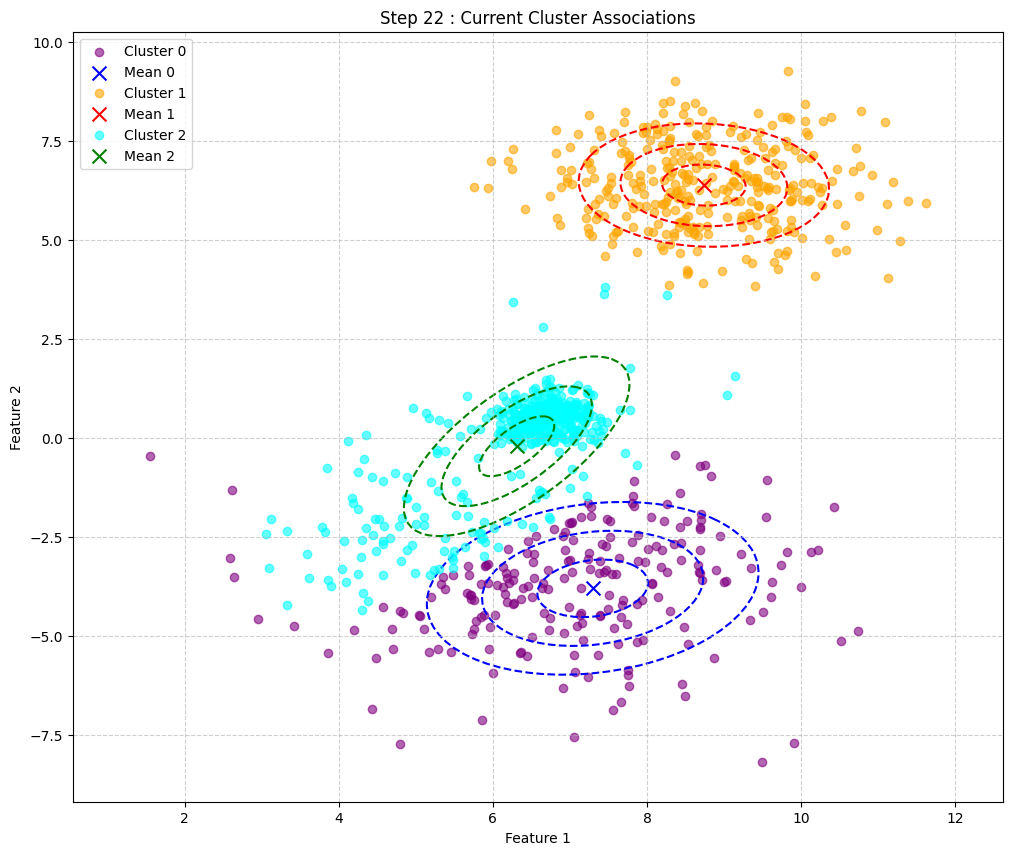

Log-Likelihood: -3931.5798226770667
Mixing Coefficients: {0: np.float64(0.21376794521216896), 1: np.float64(0.32693121810688686), 2: np.float64(0.4593008366809442)} 

Means: {0: array([ 7.07170489, -3.72057163]), 1: array([8.73554191, 6.3792181 ]), 2: array([ 6.35645858, -0.06692808])} 

Covariances: {0: array([[2.44609675, 0.25820746],
       [0.25820746, 2.08558224]]), 1: array([[ 1.17213314, -0.06399691],
       [-0.06399691,  1.08591338]]), 2: array([[0.83431025, 0.87214858],
       [0.87214858, 1.83965147]])}

Step 24


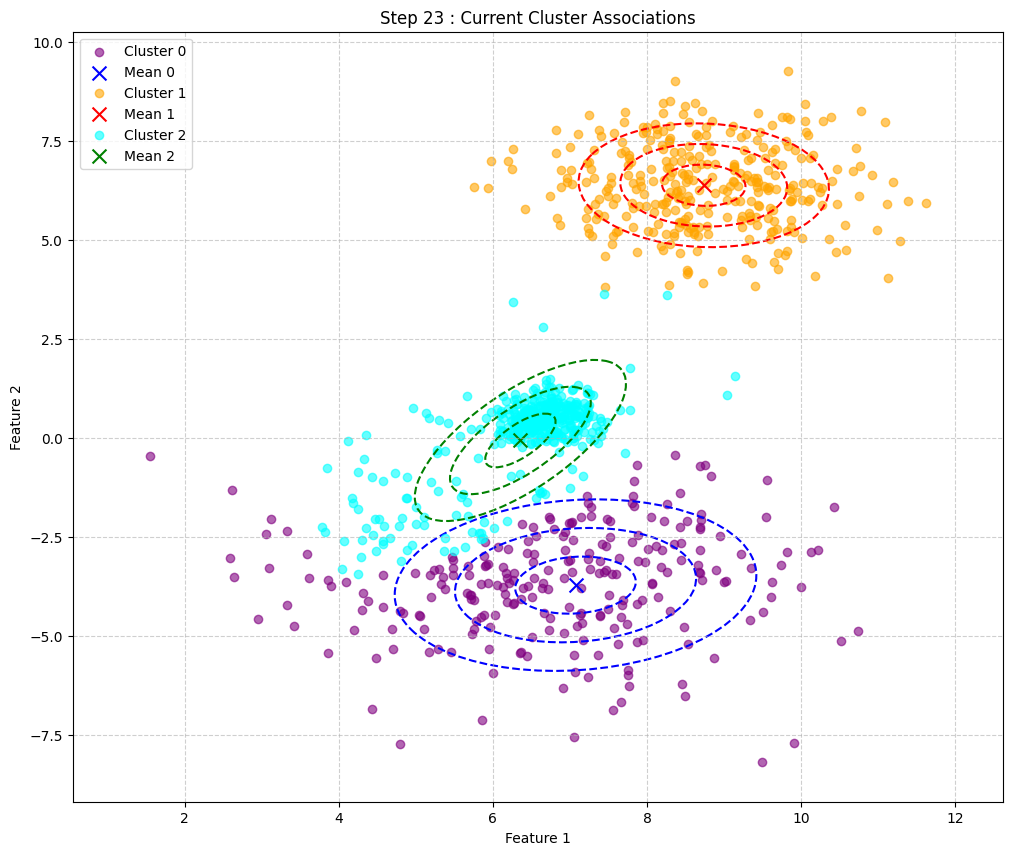

Log-Likelihood: -3868.60387597305
Mixing Coefficients: {0: np.float64(0.24307543134687706), 1: np.float64(0.32828086345648977), 2: np.float64(0.42864370519663314)} 

Means: {0: array([ 6.83398506, -3.61802372]), 1: array([8.73248091, 6.36962099]), 2: array([6.437215  , 0.11178157])} 

Covariances: {0: array([[2.78986429, 0.1191749 ],
       [0.1191749 , 2.05911013]]), 1: array([[ 1.17356641, -0.05534822],
       [-0.05534822,  1.10509615]]), 2: array([[0.63962273, 0.61751969],
       [0.61751969, 1.26370971]])}

Step 25


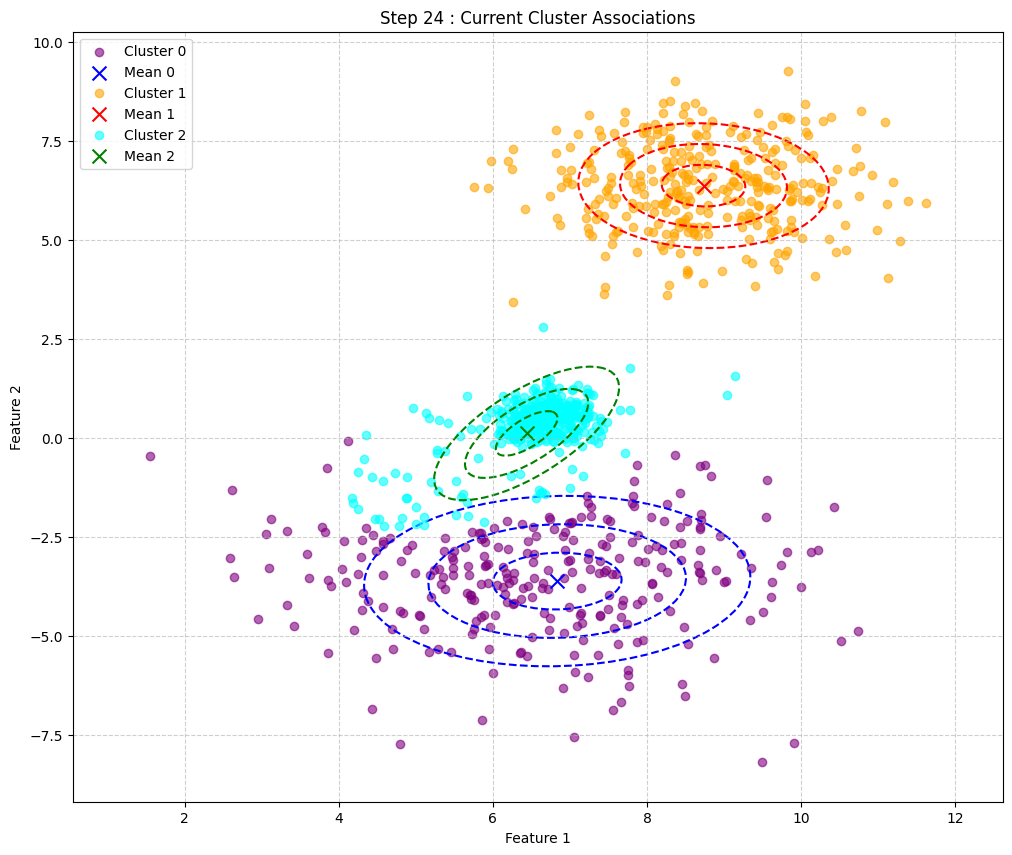

Log-Likelihood: -3777.47403980732
Mixing Coefficients: {0: np.float64(0.2728400160564879), 1: np.float64(0.3305415278453402), 2: np.float64(0.3966184560981719)} 

Means: {0: array([ 6.64546305, -3.48682305]), 1: array([8.7260979 , 6.35213848]), 2: array([6.52936319, 0.28033432])} 

Covariances: {0: array([[ 2.92533436, -0.05199793],
       [-0.05199793,  2.09874681]]), 1: array([[ 1.17798663, -0.03708457],
       [-0.03708457,  1.14307989]]), 2: array([[0.430852  , 0.33907713],
       [0.33907713, 0.69390687]])}

Step 26


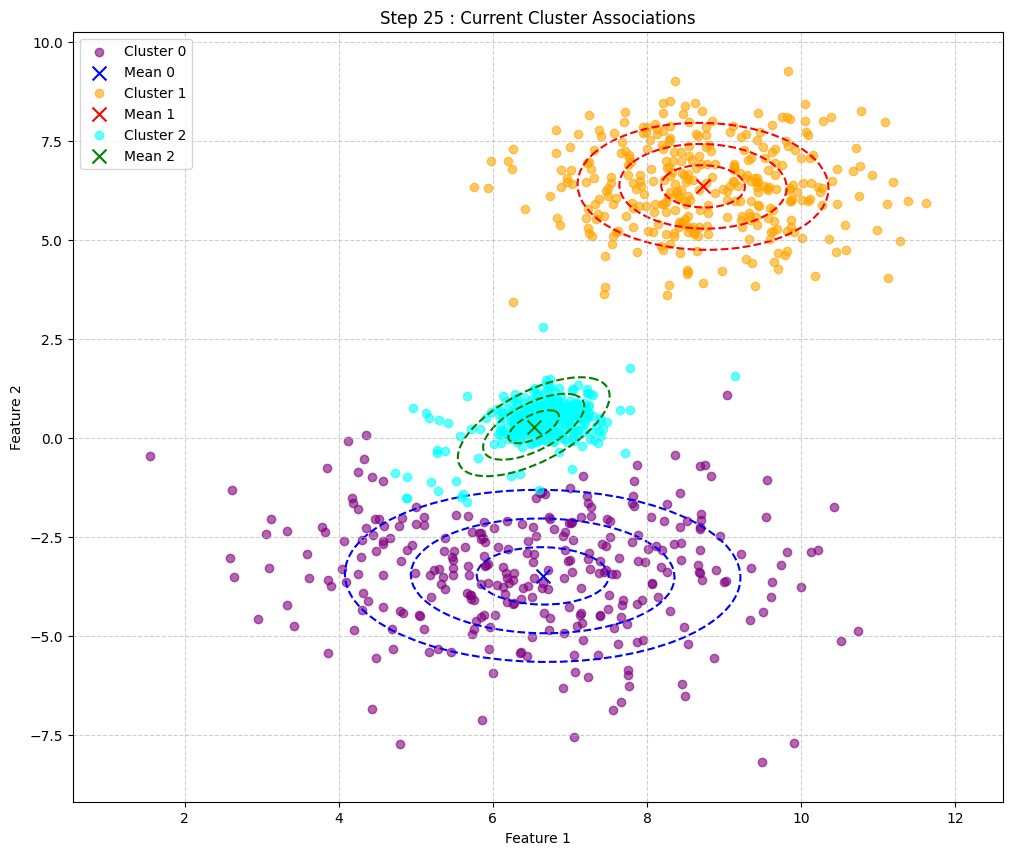

Log-Likelihood: -3661.4787842641726
Mixing Coefficients: {0: np.float64(0.2992489327223658), 1: np.float64(0.33211094220781523), 2: np.float64(0.368640125069819)} 

Means: {0: array([ 6.52622423, -3.33781649]), 1: array([8.72143772, 6.33907714]), 2: array([6.612686  , 0.41516808])} 

Covariances: {0: array([[ 2.92120642, -0.19449143],
       [-0.19449143,  2.22977978]]), 1: array([[ 1.18028332, -0.02360334],
       [-0.02360334,  1.17464791]]), 2: array([[0.25115875, 0.12256181],
       [0.12256181, 0.30080767]])}

Step 27


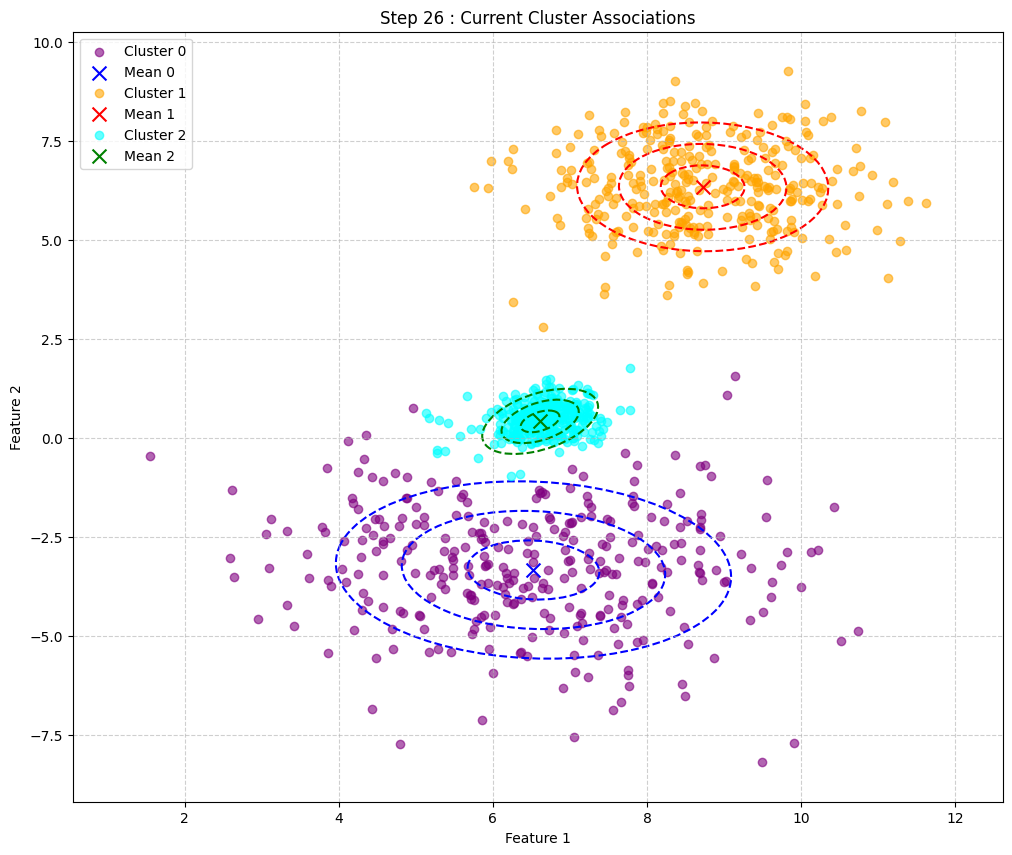

Log-Likelihood: -3593.905266734173
Mixing Coefficients: {0: np.float64(0.31665392285457333), 1: np.float64(0.3329602020421946), 2: np.float64(0.3503858751032321)} 

Means: {0: array([ 6.48110896, -3.21012597]), 1: array([8.71700607, 6.32992863]), 2: array([6.65685295, 0.4805306 ])} 

Covariances: {0: array([[ 2.86520385, -0.25581704],
       [-0.25581704,  2.43909755]]), 1: array([[ 1.18650877, -0.00813605],
       [-0.00813605,  1.2049014 ]]), 2: array([[0.15672289, 0.03551351],
       [0.03551351, 0.15033133]])}

Step 28


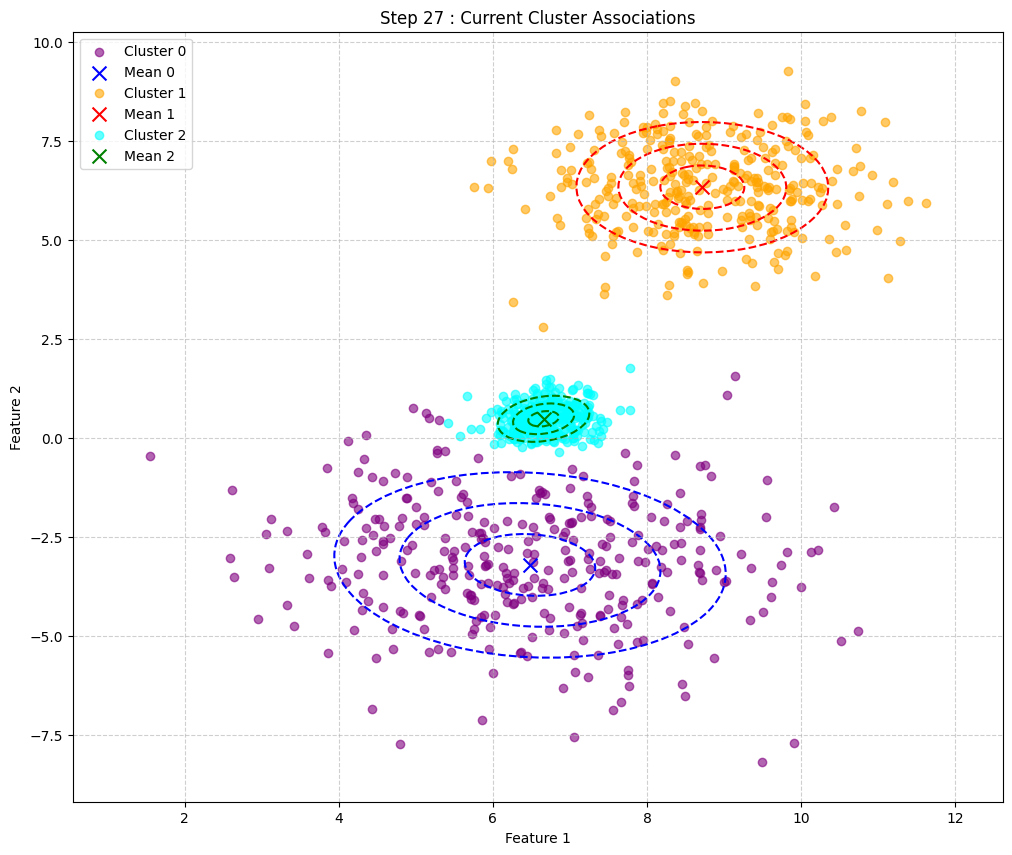

Log-Likelihood: -3583.298323232698
Mixing Coefficients: {0: np.float64(0.3257049091371374), 1: np.float64(0.33289336367542505), 2: np.float64(0.34140172718743755)} 

Means: {0: array([ 6.4662527 , -3.12562411]), 1: array([8.71730143, 6.33064302]), 2: array([6.67580067, 0.49820644])} 

Covariances: {0: array([[ 2.81372484, -0.2892355 ],
       [-0.2892355 ,  2.64016975]]), 1: array([[ 1.18593506, -0.00900126],
       [-0.00900126,  1.20252305]]), 2: array([[0.1280649 , 0.02072019],
       [0.02072019, 0.12572427]])}

Step 29


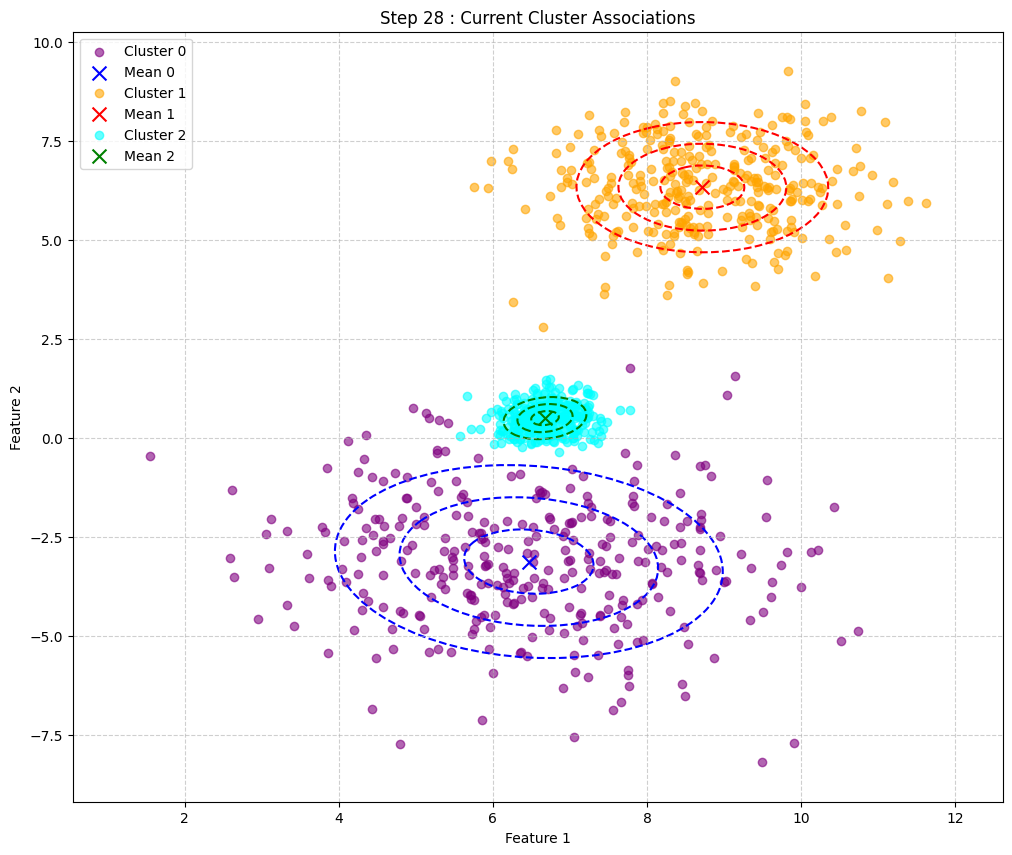

Log-Likelihood: -3581.3815242124947
Mixing Coefficients: {0: np.float64(0.3303256351280925), 1: np.float64(0.33268871491577323), 2: np.float64(0.33698564995613434)} 

Means: {0: array([ 6.46389997, -3.07558566]), 1: array([8.71838778, 6.33284312]), 2: array([6.68114751, 0.5002166 ])} 

Covariances: {0: array([[ 2.78634815, -0.28922505],
       [-0.28922505,  2.78984623]]), 1: array([[ 1.18419079, -0.01261087],
       [-0.01261087,  1.19522452]]), 2: array([[0.11698761, 0.01665777],
       [0.01665777, 0.12067299]])}

Step 30


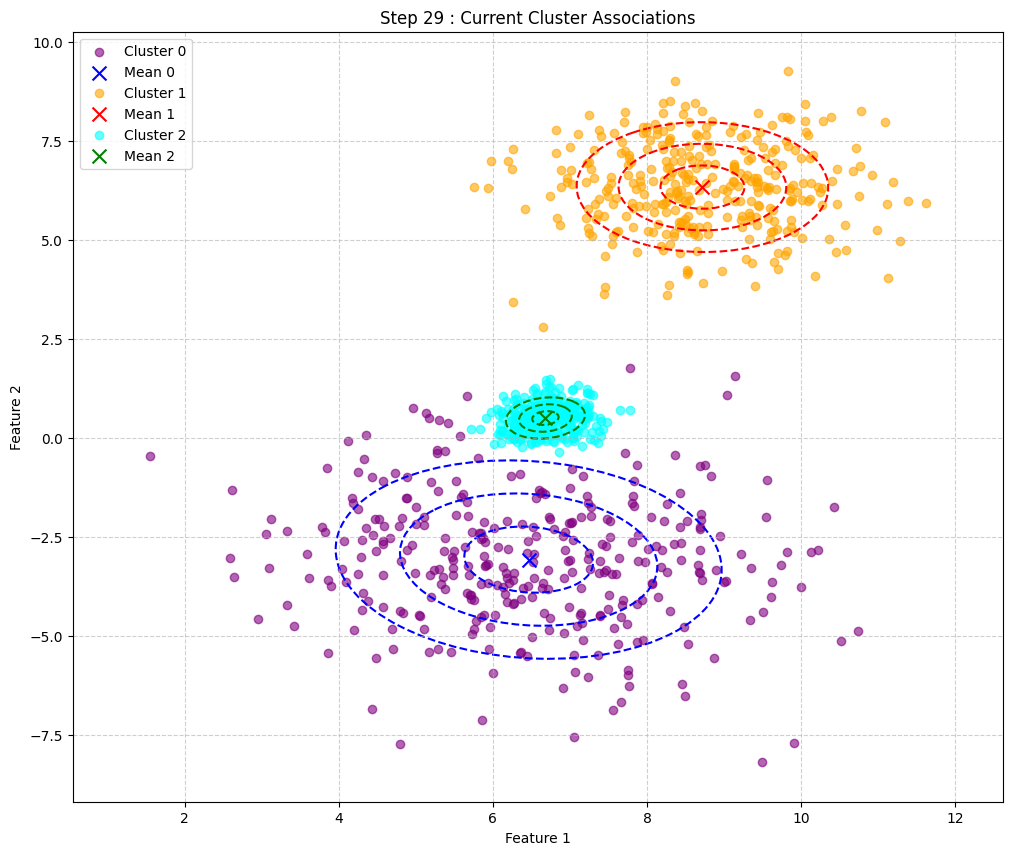

Log-Likelihood: -3581.038517530534
Mixing Coefficients: {0: np.float64(0.33264938072171524), 1: np.float64(0.33249210451481226), 2: np.float64(0.3348585147634725)} 

Means: {0: array([ 6.46385563, -3.04990859]), 1: array([8.71946822, 6.33495187]), 2: array([6.6828225 , 0.50085391])} 

Covariances: {0: array([[ 2.771631  , -0.28615501],
       [-0.28615501,  2.86930987]]), 1: array([[ 1.18252101, -0.016247  ],
       [-0.016247  ,  1.18823053]]), 2: array([[0.11308339, 0.01576867],
       [0.01576867, 0.11936581]])}

Step 31


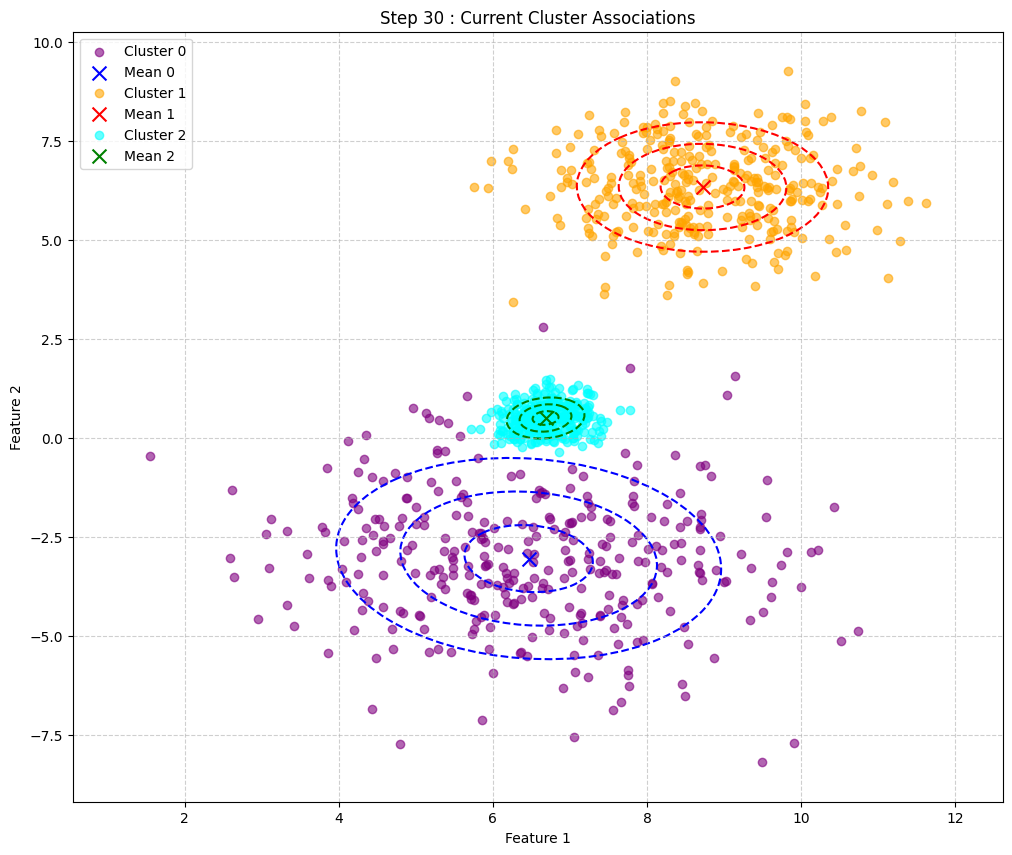

Log-Likelihood: -3580.9729828125055
Mixing Coefficients: {0: np.float64(0.33375086339501), 1: np.float64(0.3323751894069355), 2: np.float64(0.3338739471980546)} 

Means: {0: array([ 6.46414032, -3.03768589]), 1: array([8.72013814, 6.33618164]), 2: array([6.68330658, 0.50116873])} 

Covariances: {0: array([[ 2.76443366, -0.28387334],
       [-0.28387334,  2.90768683]]), 1: array([[ 1.18146386, -0.01848152],
       [-0.01848152,  1.18424657]]), 2: array([[0.11163582, 0.01559014],
       [0.01559014, 0.11892725]])}

Step 32


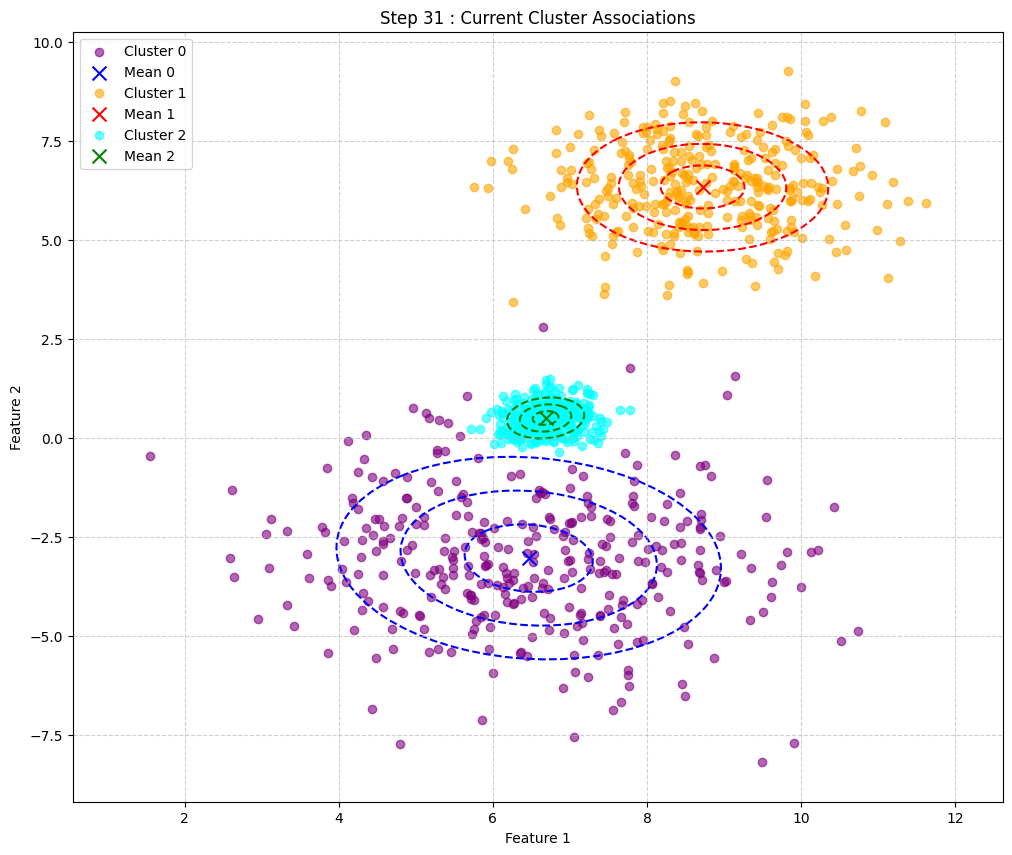

Log-Likelihood: -3580.9599138876965
Mixing Coefficients: {0: np.float64(0.3342575305217016), 1: np.float64(0.33231628622645826), 2: np.float64(0.33342618325184015)} 

Means: {0: array([ 6.46435066, -3.03204665]), 1: array([8.72048315, 6.33679329]), 2: array([6.68344472, 0.5013142 ])} 

Covariances: {0: array([[ 2.76108384, -0.2825932 ],
       [-0.2825932 ,  2.92556887]]), 1: array([[ 1.18091105, -0.01962371],
       [-0.01962371,  1.18229604]]), 2: array([[0.11105421, 0.01555096],
       [0.01555096, 0.11874547]])}

Step 33


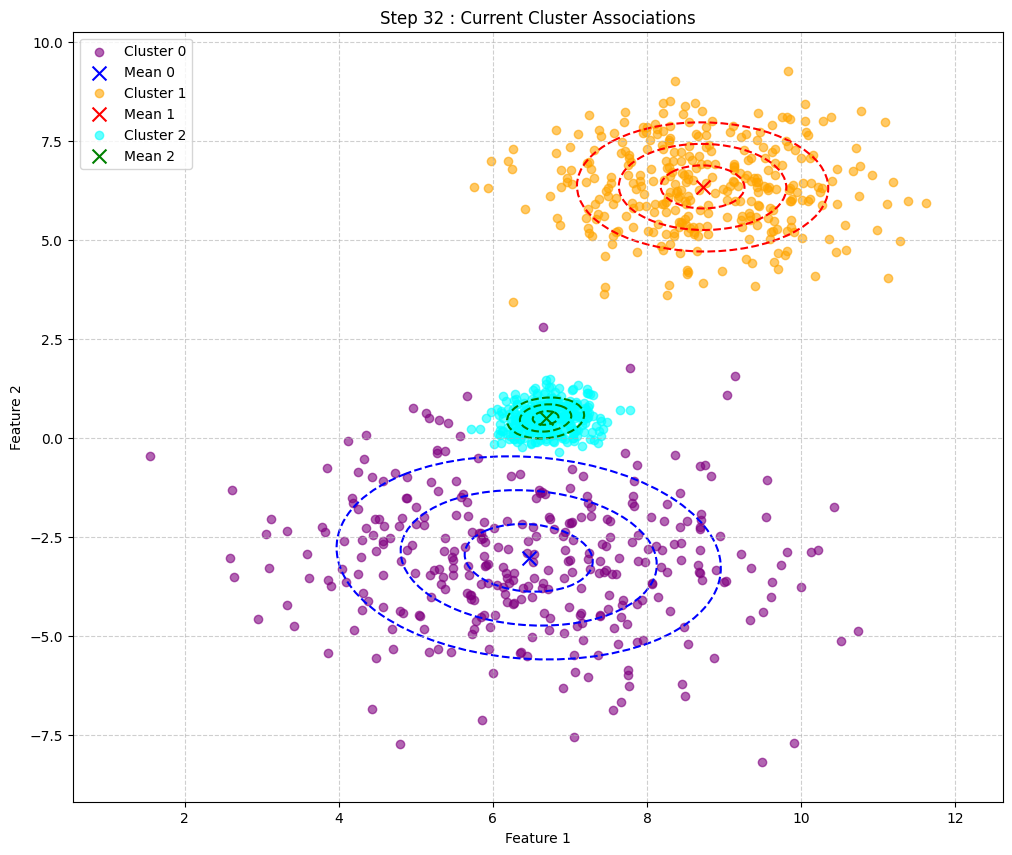

Log-Likelihood: -3580.957270281435
Mixing Coefficients: {0: np.float64(0.33448809038560223), 1: np.float64(0.33228843165043914), 2: np.float64(0.3332234779639587)} 

Means: {0: array([ 6.46446439, -3.02947641]), 1: array([8.72064795, 6.33708062]), 2: array([6.68348809, 0.50138024])} 

Covariances: {0: array([[ 2.75955202, -0.28195688],
       [-0.28195688,  2.93376121]]), 1: array([[ 1.18064495, -0.02016705],
       [-0.02016705,  1.18138723]]), 2: array([[0.11080717, 0.01554106],
       [0.01554106, 0.11866488]])}

Step 34


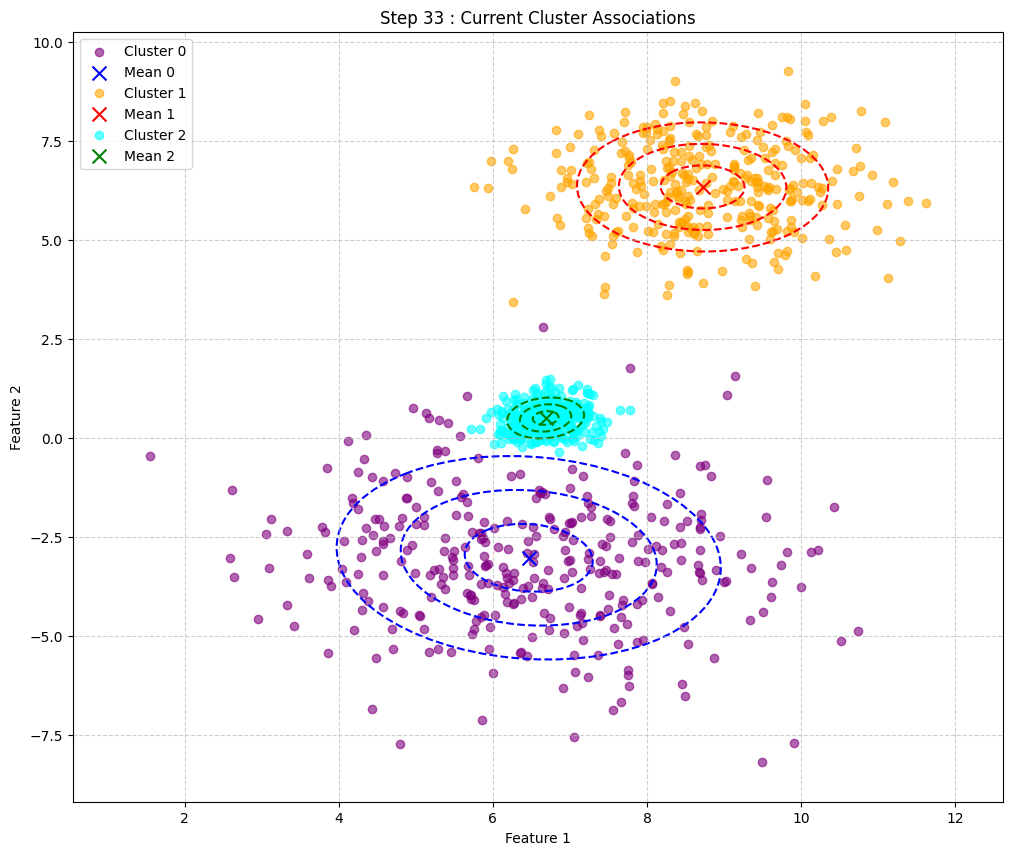

Log-Likelihood: -3580.9567331110065
Mixing Coefficients: {0: np.float64(0.33459254216285217), 1: np.float64(0.33227560003743567), 2: np.float64(0.3331318577997122)} 

Means: {0: array([ 6.46451975, -3.02831113]), 1: array([8.72072421, 6.33721256]), 2: array([6.68350356, 0.50141011])} 

Covariances: {0: array([[ 2.75885652, -0.28165701],
       [-0.28165701,  2.93748448]]), 1: array([[ 1.18052136, -0.02041797],
       [-0.02041797,  1.18097154]]), 2: array([[0.11069893, 0.01553812],
       [0.01553812, 0.11862862]])}

Step 35


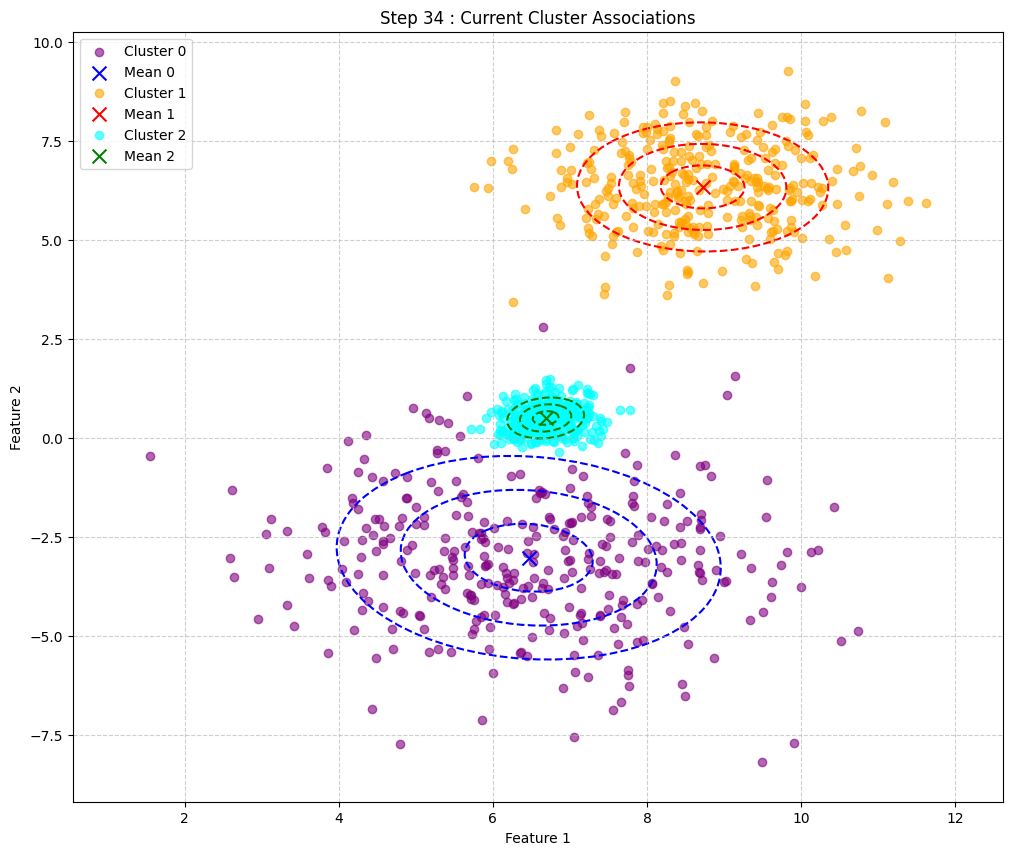

Log-Likelihood: -3580.956623791617
Mixing Coefficients: {0: np.float64(0.3346397673683289), 1: np.float64(0.33226975535411635), 2: np.float64(0.3330904772775548)} 

Means: {0: array([ 6.46454559, -3.02778409]), 1: array([8.72075902, 6.33727257]), 2: array([6.68350968, 0.50142361])} 

Covariances: {0: array([[ 2.75854176, -0.28151901],
       [-0.28151901,  2.93917033]]), 1: array([[ 1.18046486, -0.02053238],
       [-0.02053238,  1.18078281]]), 2: array([[0.11065076, 0.0155371 ],
       [0.0155371 , 0.11861225]])}

Step 36


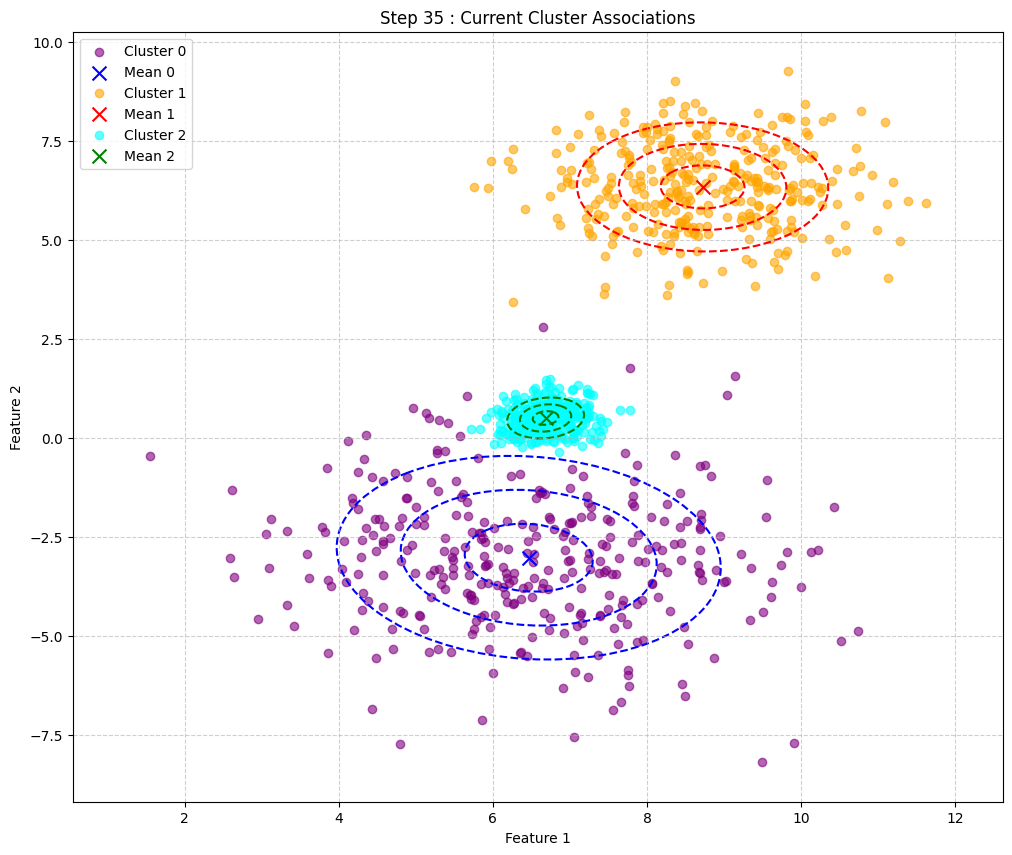

Log-Likelihood: -3580.956601531076
Convergence reached at step 36.

Final Parameters:
Mixing Coefficients: {0: np.float64(0.33466109916045444), 1: np.float64(0.3322671064388612), 2: np.float64(0.33307179440068435)}
Means: {0: array([ 6.46455742, -3.02754599]), 1: array([8.72077481, 6.33729974]), 2: array([6.68351227, 0.5014297 ])}
Covariances: {0: array([[ 2.75839951, -0.28145618],
       [-0.28145618,  2.93993234]]), 1: array([[ 1.18043921, -0.02058427],
       [-0.02058427,  1.1806974 ]]), 2: array([[0.11062916, 0.0155367 ],
       [0.0155367 , 0.11860486]])}


<Figure size 640x480 with 0 Axes>

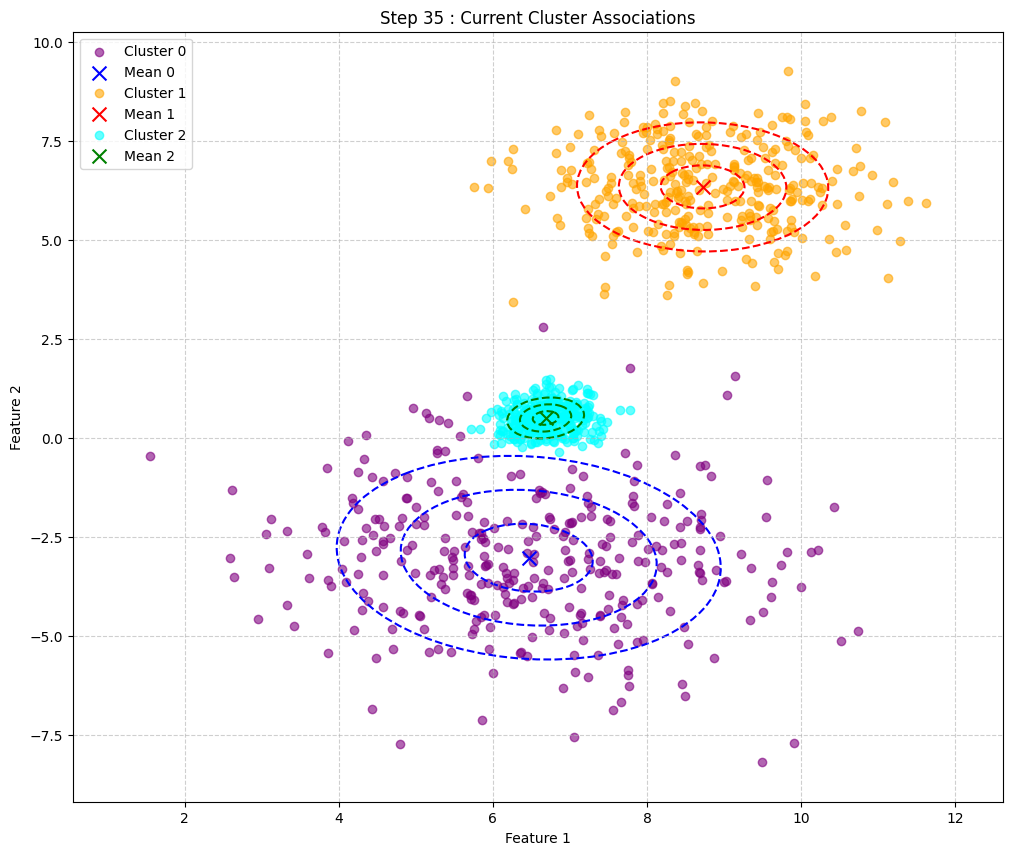

In [11]:
# Example usage
mixing_dic, mean_dic, cov_dic = train_gmm(X, n_components=k, n_steps=300, plot_intermediate_steps_flag=True)